In [2]:
import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader

import models.loadImg as loadImg
import models.modelsCNN as modelsCNN
import models.optimizer as optimizer

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
from skimage import io
import scipy.stats
from sklearn.metrics import pairwise_distances

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '3,2,1,0'
use_cuda=True
datadir='/media/xinyi/dcis2idc/data'
name='exp0'
plotsavepath='/media/xinyi/dcis2idc/plots/cnnvae'+name
sampledir=plotsavepath
clustersavedir_alltrain=os.path.join(sampledir,'cluster_alltrain_reordered')
ep=311
with open(os.path.join(datadir,'processed','train_cnnvae_names'), 'rb') as input:
    allImgNames=pickle.load(input)
#plot by disease progression
br1003aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR1003a specs.xlsx',header=10)
br301Specs=pd.read_excel('/media/xinyi/dcis2idc/data/BR301 specs.xlsx',header=10)
br8018aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR8018a specs.xlsx',header=10)
br1003aSpecs.index=br1003aSpecs.loc[:,'Position']
br301Specs.index=br301Specs.loc[:,'Position']
br8018aSpecs.index=br8018aSpecs.loc[:,'Position']

progList=np.copy(allImgNames)
for s in np.unique(allImgNames):
    ssplit=s.split('_')
    if 'br1003a'==ssplit[0]:
        prog_s=br1003aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br301'==ssplit[0]:
        prog_s=br301Specs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br8018a'==ssplit[0]:
        prog_s=br8018aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    progList[allImgNames==s]=prog_s
    




In [4]:
savenamesample='alltrain'

neworder=[1, 5, 3, 7, 2, 0, 4, 6]
#use chosen subcluster number and save plots
scanpy.settings.verbosity = 3
# subcluster=8
subclusterDict={0:[4],1:[6],2:[8],3:[6],4:[6],5:[6],6:[6],7:[4]}
ncluster=8

plotepoch=311
clusterplotdir=os.path.join(clustersavedir_alltrain,'plots')
n_pcs=50
savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
with open(os.path.join(clustersavedir_alltrain,'minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'rb') as output:
    clusterRes=pickle.load(output)

kmeans_sub=(np.zeros(clusterRes.size)-1).astype(str)
savenameAdd='_plottingIdx_progBalanced_'+str(0)
subclusternumbers=[4,6,8,6,6,6,6,4]
savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+savenameAdd
for cnew in np.unique(clusterRes):
#     print('cluster'+str(c))
    c=neworder[cnew]
    
    subclustersavedir_alltrain=os.path.join(clustersavedir_alltrain,savenamecluster+'_subcluster'+str(c))
    with open(os.path.join(subclustersavedir_alltrain,'minibatchkmean_ncluster'+str(subclusternumbers[c])+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'rb') as output:
        subclusterRes=pickle.load(output)
    print(np.unique(subclusterRes))
    kmeans_sub[clusterRes==cnew]=np.char.add(np.repeat(str(cnew)+'-',subclusterRes.size),subclusterRes.astype(str))
   

[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3]
[0 1 2 3 4 5 6 7]
[0 1 2 3]
[0 1 2 3 4 5]
[0 1 2 3 4 5]


In [5]:
with open(os.path.join(datadir,'processed','train_cnnvae_coord'), 'rb') as output:
    coordlist=pickle.load(output)

In [6]:
for p in np.unique(progList):
    if p=='Ductal carcinoma in situ':
        progList[progList==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ and breast tissue':
        progList[progList==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ with early infiltratio':
        progList[progList==p]='DCIS with early infiltration'
    
    elif p=='Micropapillary type ductal carcinoma in situ wi':
        progList[progList==p]='DCIS with early infiltration'    
#     elif p=='Atypical hyperlasia': #wrong name; not counted
#         progList[progList==p]='Hyperplasia'

In [7]:
progInclude=np.array(['Breast tissue','Cancer adjacent normal breast tissue','Hyperplasia','Atypical hyperplasia','DCIS and breast tissue',
                     'DCIS with early infiltration','Invasive ductal carcinoma and breast tissue','Invasive ductal carcinoma'])

In [8]:
progIncludeIdx=np.repeat(False,progList.size)
for p in progInclude:
    progIncludeIdx[progList==p]=True
    
coordlist=coordlist[progIncludeIdx]
allImgNames=allImgNames[progIncludeIdx]
clusterRes=clusterRes[progIncludeIdx]
kmeans_sub=kmeans_sub[progIncludeIdx]
progList=progList[progIncludeIdx]

In [9]:
sUnique,sidx_start=np.unique(allImgNames,return_index=True)
progUnique,labels_train,progCounts=np.unique(progList[sidx_start],return_counts=True,return_inverse=True)
for p in range(progUnique.size):
    print(progUnique[p])
    print(progCounts[p])

Atypical hyperplasia
14
Breast tissue
20
Cancer adjacent normal breast tissue
13
DCIS and breast tissue
16
DCIS with early infiltration
30
Hyperplasia
41
Invasive ductal carcinoma
70
Invasive ductal carcinoma and breast tissue
8


In [10]:
def getHistMatrix_clusters(labels,ctlist,nrow=ncluster,ncol=ncluster):
    res=np.zeros((nrow,ncol))
    for li in range(res.shape[0]):
        l=li
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=ci
            res[l,c]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
        if nl!=0:
            res[li]=res[li]/nl
    return res

neighborhoodSize=16*9

In [12]:
#get neighborhood composition

inputNeighborhood=np.zeros((sUnique.size,ncluster*ncluster))
for i in range(sUnique.size):
    imgN=sUnique[i]
    nsamples=np.sum(allImgNames==imgN)
    cluster_i=clusterRes[allImgNames==imgN]
    neighbor_i=np.tile(cluster_i,(nsamples,1))
    self_i=np.tile(cluster_i.reshape((-1,1)),(1,nsamples))

    dist=pairwise_distances(coordlist[allImgNames==imgN],n_jobs=-1)
    distIn=np.logical_and(dist<neighborhoodSize,dist>0)
    res=getHistMatrix_clusters(self_i[distIn],neighbor_i[distIn])
    
    inputNeighborhood[i]=res.flatten()

In [13]:
_,inputCounts=np.unique(allImgNames,return_counts=True)
inputAll_train=np.concatenate((inputNeighborhood,inputCounts.reshape(-1,1)),axis=1)

In [14]:
#val cores (as validation cores) and val samples (as test cores)
clustersavedir_valcores=os.path.join(sampledir,'cluster_valcores_reordered')
clustersavedir_valsamples=os.path.join(sampledir,'cluster_valsamples_reordered')

with open(os.path.join(datadir,'processed','train_cnnvae_coord_valcores'), 'rb') as output:
    coordlist_valcores=pickle.load(output)
with open(os.path.join(datadir,'processed','train_cnnvae_coord_valsamples'), 'rb') as output:
    coordlist_valsamples=pickle.load(output)

savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
with open(os.path.join(clustersavedir_valcores,savenamecluster+'_all'), 'rb') as output:
    clusterRes_valcores=pickle.load(output)
with open(os.path.join(clustersavedir_valsamples,'minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'rb') as output:
    clusterRes_valsamples=pickle.load(output)
    
kmeans_sub_valcores=(np.zeros(clusterRes_valcores.size)-1).astype(str)
for c in np.unique(clusterRes_valcores):
    subclustersavedir=os.path.join(clustersavedir_valcores,savenamecluster+'_plottingIdx_progBalanced_'+str(0)+'_subcluster'+str(neworder[c]))
    with open(os.path.join(subclustersavedir,'minibatchkmean_ncluster'+str(subclusterDict[neworder[c]][0])+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'rb') as output:
        subclusterRes=pickle.load(output)
    kmeans_sub_valcores[clusterRes_valcores==c]=np.char.add(np.repeat(str(c)+'-',subclusterRes.size),subclusterRes.astype(str))
    
kmeans_sub_valsamples=(np.zeros(clusterRes_valsamples.size)-1).astype(str)
for c in np.unique(clusterRes_valsamples):
    subclustersavedir=os.path.join(clustersavedir_valsamples,savenamecluster+'_plottingIdx_progBalanced_'+str(0)+'_subcluster'+str(neworder[c]))
    with open(os.path.join(subclustersavedir,'minibatchkmean_ncluster'+str(subclusterDict[neworder[c]][0])+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'rb') as output:
        subclusterRes=pickle.load(output)
    kmeans_sub_valsamples[clusterRes_valsamples==c]=np.char.add(np.repeat(str(c)+'-',subclusterRes.size),subclusterRes.astype(str))
                

In [15]:
with open(os.path.join(datadir,'processed','train_cnnvae_names_valcores'), 'rb') as input:
    allImgNames_valcores=pickle.load(input)
with open(os.path.join(datadir,'processed','train_cnnvae_names_valsamples'), 'rb') as input:
    allImgNames_valsamples=pickle.load(input)

In [16]:
#plot by disease progression
br1003aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR1003a specs.xlsx',header=10)
br301Specs=pd.read_excel('/media/xinyi/dcis2idc/data/BR301 specs.xlsx',header=10)
br8018aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR8018a specs.xlsx',header=10)
br1003aSpecs.index=br1003aSpecs.loc[:,'Position']
br301Specs.index=br301Specs.loc[:,'Position']
br8018aSpecs.index=br8018aSpecs.loc[:,'Position']

progList_valcores=np.copy(allImgNames_valcores)
for s in np.unique(allImgNames_valcores):
    ssplit=s.split('_')
    if 'br1003a'==ssplit[0]:
        prog_s=br1003aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br301'==ssplit[0]:
        prog_s=br301Specs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br8018a'==ssplit[0]:
        prog_s=br8018aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    progList_valcores[allImgNames_valcores==s]=prog_s
    
progList_valsamples=np.copy(allImgNames_valsamples)
for s in np.unique(allImgNames_valsamples):
    ssplit=s.split('_')
    if 'br1003a'==ssplit[0]:
        prog_s=br1003aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br301'==ssplit[0]:
        prog_s=br301Specs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br8018a'==ssplit[0]:
        prog_s=br8018aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    progList_valsamples[allImgNames_valsamples==s]=prog_s
    



In [17]:
for p in np.unique(progList_valcores):
    if p=='Ductal carcinoma in situ':
        progList_valcores[progList_valcores==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ and breast tissue':
        progList_valcores[progList_valcores==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ with early infiltratio':
        progList_valcores[progList_valcores==p]='DCIS with early infiltration'
    
    elif p=='Micropapillary type ductal carcinoma in situ wi':
        progList_valcores[progList_valcores==p]='DCIS with early infiltration'    
#     elif p=='Atypical hyperlasia':
#         progList_valcores[progList_valcores==p]='Hyperplasia'

In [18]:
for p in np.unique(progList_valsamples):
    if p=='Ductal carcinoma in situ':
        progList_valsamples[progList_valsamples==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ and breast tissue':
        progList_valsamples[progList_valsamples==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ with early infiltrati':
        progList_valsamples[progList_valsamples==p]='DCIS with early infiltration'
    
    elif p=='Micropapillary type ductal carcinoma in situ w':
        progList_valsamples[progList_valsamples==p]='DCIS with early infiltration'    
#     elif p=='Atypical hyperlasia':
#         progList_valsamples[progList_valsamples==p]='Hyperplasia'

In [19]:
progIncludeIdx_valcores=np.repeat(False,progList_valcores.size)
for p in progInclude:
    progIncludeIdx_valcores[progList_valcores==p]=True
    
progIncludeIdx_valsamples=np.repeat(False,progList_valsamples.size)
for p in progInclude:
    progIncludeIdx_valsamples[progList_valsamples==p]=True
    
coordlist_valcores=coordlist_valcores[progIncludeIdx_valcores]
allImgNames_valcores=allImgNames_valcores[progIncludeIdx_valcores]
clusterRes_valcores=clusterRes_valcores[progIncludeIdx_valcores]
kmeans_sub_valcores=kmeans_sub_valcores[progIncludeIdx_valcores]
progList_valcores=progList_valcores[progIncludeIdx_valcores]

coordlist_valsamples=coordlist_valsamples[progIncludeIdx_valsamples]
allImgNames_valsamples=allImgNames_valsamples[progIncludeIdx_valsamples]
clusterRes_valsamples=clusterRes_valsamples[progIncludeIdx_valsamples]
kmeans_sub_valsamples=kmeans_sub_valsamples[progIncludeIdx_valsamples]
progList_valsamples=progList_valsamples[progIncludeIdx_valsamples]


In [20]:
sUnique_valcores,sidx_start_valcores=np.unique(allImgNames_valcores,return_index=True)
progUnique_valcores,progCounts_valcores=np.unique(progList_valcores[sidx_start_valcores],return_counts=True)
for p in range(progUnique_valcores.size):
    print(progUnique_valcores[p])
    print(progCounts_valcores[p])

Atypical hyperplasia
15
Breast tissue
20
Cancer adjacent normal breast tissue
1
Hyperplasia
35
Invasive ductal carcinoma
97


In [21]:
sUnique_valsamples,sidx_start_valsamples=np.unique(allImgNames_valsamples,return_index=True)
progUnique_valsamples,progCounts_valsamples=np.unique(progList_valsamples[sidx_start_valsamples],return_counts=True)
for p in range(progUnique_valsamples.size):
    print(progUnique_valsamples[p])
    print(progCounts_valsamples[p])

Atypical hyperplasia
10
Breast tissue
14
Cancer adjacent normal breast tissue
4
DCIS and breast tissue
16
DCIS with early infiltration
29
Hyperplasia
25
Invasive ductal carcinoma
66
Invasive ductal carcinoma and breast tissue
8


In [22]:
#construct labels
labels_valcores=np.zeros(progList_valcores[sidx_start_valcores].size)
for i in range(progUnique.size):
    labels_valcores[progList_valcores[sidx_start_valcores]==progUnique[i]]=i

In [23]:
#construct labels
labels_valsamples=np.zeros(progList_valsamples[sidx_start_valsamples].size)
for i in range(progUnique.size):
    labels_valsamples[progList_valsamples[sidx_start_valsamples]==progUnique[i]]=i

In [24]:
inputNeighborhood_valcores=np.zeros((sUnique_valcores.size,ncluster*ncluster))
for i in range(sUnique_valcores.size):
    imgN=sUnique_valcores[i]
    nsamples=np.sum(allImgNames_valcores==imgN)
    cluster_i=clusterRes_valcores[allImgNames_valcores==imgN]
    neighbor_i=np.tile(cluster_i,(nsamples,1))
    self_i=np.tile(cluster_i.reshape((-1,1)),(1,nsamples))

    dist=pairwise_distances(coordlist_valcores[allImgNames_valcores==imgN],n_jobs=-1)
    distIn=np.logical_and(dist<neighborhoodSize,dist>0)
    res=getHistMatrix_clusters(self_i[distIn],neighbor_i[distIn])
    
    inputNeighborhood_valcores[i]=res.flatten()

In [25]:
inputNeighborhood_valsamples=np.zeros((sUnique_valsamples.size,ncluster*ncluster))
for i in range(sUnique_valsamples.size):
    imgN=sUnique_valsamples[i]
    nsamples=np.sum(allImgNames_valsamples==imgN)
    cluster_i=clusterRes_valsamples[allImgNames_valsamples==imgN]
    neighbor_i=np.tile(cluster_i,(nsamples,1))
    self_i=np.tile(cluster_i.reshape((-1,1)),(1,nsamples))

    dist=pairwise_distances(coordlist_valsamples[allImgNames_valsamples==imgN],n_jobs=-1)
    distIn=np.logical_and(dist<neighborhoodSize,dist>0)
    res=getHistMatrix_clusters(self_i[distIn],neighbor_i[distIn])
    
    inputNeighborhood_valsamples[i]=res.flatten()

In [26]:
_,inputCounts_valcores=np.unique(allImgNames_valcores,return_counts=True)
inputAll_valcores=np.concatenate((inputNeighborhood_valcores,inputCounts_valcores.reshape(-1,1)),axis=1)

In [27]:
_,inputCounts_valsamples=np.unique(allImgNames_valsamples,return_counts=True)
inputAll_valsamples=np.concatenate((inputNeighborhood_valsamples,inputCounts_valsamples.reshape(-1,1)),axis=1)

In [28]:
#concatenate cores
inputAll=np.concatenate((inputAll_train,np.concatenate((inputAll_valcores,inputAll_valsamples),axis=0)),axis=0)
imgNamesAll=np.concatenate((allImgNames[sidx_start],np.concatenate((allImgNames_valcores[sidx_start_valcores],allImgNames_valsamples[sidx_start_valsamples]))))
labelsAll=np.concatenate((labels_train,np.concatenate((labels_valcores,labels_valsamples))))

In [29]:
_,progCountsAll=np.unique(labelsAll,return_counts=True)
weights_train=np.sum(progCountsAll)/progCountsAll

In [30]:
clusterResAll=np.concatenate((clusterRes[sidx_start],np.concatenate((clusterRes_valcores[sidx_start_valcores],clusterRes_valsamples[sidx_start_valsamples]))))

In [31]:
#normalize count
with open(os.path.join(datadir,'processed','imgSizeByPath'), 'rb') as output:
    imgSize_median=pickle.load(output)
areaAll=np.zeros(labelsAll.size)
for s in range(labelsAll.size):
    areaAll[s]=imgSize_median[progUnique[labelsAll.astype(int)][s]]
inputAll[:,-1]=inputAll[:,-1]/areaAll

In [32]:
seed=3
epochs=6000
saveFreq=200
lr=0.001 #initial learning rate
weight_decay=0 

# batchsize=4
batchsize=6000
model_str='fc3'

fc_dim1=64
fc_dim2=64
fc_dim3=64


dropout=0.01

name='exp0_pathologyClf_neighbor_clusters_exp0_subset_neighborOnly_crossVal_ablation_countAreaNorm_wAH'
logsavepath='/media/xinyi/dcis2idc/log/cnnvae'+name
modelsavepath='/media/xinyi/dcis2idc/models/cnnvae'+name
plotsavepath='/media/xinyi/dcis2idc/plots/cnnvae'+name


if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)



In [33]:
def train(epoch,trainInput,labels_train):
    t = time.time()
    model.train()
    optimizer.zero_grad()

    pred = model(trainInput)

    loss=lossCE(pred,labels_train)

    loss.backward()
    optimizer.step()

    if epoch%500==0:
        print('Epoch: {:04d}'.format(epoch),
              'loss_train: {:.4f}'.format(loss))
    return loss.item()

In [34]:

labelsAll=torch.tensor(labelsAll).cuda().long()

In [35]:
#plot confusion
def plotCTcomp(labels,ctlist,savepath,savenamecluster,byCT,addname='',order=progInclude):
    res=np.zeros((order.size,order.size))
    for li in range(res.shape[0]):
        l=order[li]
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=order[ci]
            res[li,ci]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
    if not byCT:
        addname+=''
        for li in range(res.shape[0]):
            l=order[li]
            nl=np.sum(labels==l)
            res[li]=res[li]/nl
    else:
        addname+='_normbyCT'
        for ci in range(res.shape[1]):
            c=order[ci]
            nc=np.sum(ctlist==c)
            res[:,ci]=res[:,ci]/nc
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='binary',vmin=0,vmax=1)
    fig.colorbar(im)
    ax.set_yticks(np.arange(order.size))
    ax.set_yticklabels(order)
    ax.set_xticks(np.arange(order.size))
    ax.set_xticklabels(order)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,savenamecluster+addname+'.pdf'))
    plt.close()
    


In [36]:
for c in np.unique(clusterResAll):
# for c in [5,6,7]:
    print('cluster'+str(c))
    mask=np.repeat(True,64).reshape(8,8)
    mask[c]=False
    mask[:,c]=False
    mask=np.concatenate((mask.flatten(),[True]))
    inputAll_c=np.copy(inputAll[:,mask])
    
    nc=np.unique(clusterResAll).size-1
    for ci in range(nc):
        inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)
    inputAll_c[np.logical_not(np.isfinite(inputAll_c))]=0
    
    if not os.path.exists(os.path.join(modelsavepath,str(c))):
        os.mkdir(os.path.join(modelsavepath,str(c)))
    if not os.path.exists(os.path.join(logsavepath,str(c))):
        os.mkdir(os.path.join(logsavepath,str(c)))
    if not os.path.exists(os.path.join(plotsavepath,str(c))):
        os.mkdir(os.path.join(plotsavepath,str(c)))
    
    inputAll_c=scipy.stats.zscore(inputAll_c,axis=0)
    inputAll_c=torch.tensor(inputAll_c).cuda().float()
    
    testepoch=5800
    predtest=np.zeros((inputAll_c.shape[0],np.unique(labels_train).size))
    for sampleIdx in range(inputAll_c.shape[0]):

        trainIdx=np.arange(inputAll_c.shape[0])!=sampleIdx

        seed=3
        torch.manual_seed(seed)
        nclasses=np.unique(labels_train).size
        if use_cuda:
            torch.cuda.manual_seed(seed)

        nfeatures=inputAll_c.shape[1]
        if model_str=='fc3':
            model = modelsCNN.FC_l3(nfeatures,fc_dim1,fc_dim2,fc_dim3,nclasses,0.5,regrs=False)
            lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weights_train).cuda().float())
        if model_str=='fc5':
            model = modelsCNN.FC_l5(nfeatures,fc_dim1,fc_dim2,fc_dim3,fc_dim4,fc_dim5,nclasses,0.5,regrs=False)
            lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weights_train).cuda().float())
        if model_str=='fc1':
            model = modelsCNN.FC_l1(nfeatures,fc_dim1,nclasses,regrs=False)
            lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weights_train).cuda().float())
        if model_str=='fc0':
            model = modelsCNN.FC_l0(nfeatures,nclasses,regrs=False)
            lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weights_train).cuda().float())

        if use_cuda:
            model.cuda()

        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        train_loss_ep=[None]*epochs
        val_loss_ep=[None]*epochs
        t_ep=time.time()

#         if os.path.exists(os.path.join(modelsavepath,str(c),imgNamesAll[sampleIdx]+'_'+str(testepoch)+'.pt')):
#             model.load_state_dict(torch.load(os.path.join(modelsavepath,str(c),imgNamesAll[sampleIdx]+'_'+str(testepoch)+'.pt')))
#             with torch.no_grad():
#                 model.cuda()
#                 model.eval()
#                 pred = model(inputAll_c[[sampleIdx]])
#                 predtest[sampleIdx]=pred.cpu().detach().numpy()

#                 loss_test=lossCE(pred,labelsAll[[sampleIdx]]).item()
#             continue
            
            
        for ep in range(epochs):
            train_loss_ep[ep]=train(ep,inputAll_c[trainIdx],labelsAll[trainIdx])


            if ep%saveFreq == 0 and ep!=0:
                torch.save(model.cpu().state_dict(), os.path.join(modelsavepath,str(c),imgNamesAll[sampleIdx]+'_'+str(ep)+'.pt'))
            if use_cuda:
                model.cuda()
                torch.cuda.empty_cache()
        print(' total time: {:.4f}s'.format(time.time() - t_ep))

        with open(os.path.join(logsavepath,str(c),imgNamesAll[sampleIdx]+'_train_loss'), 'wb') as output:
            pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)

        model.load_state_dict(torch.load(os.path.join(modelsavepath,str(c),imgNamesAll[sampleIdx]+'_'+str(testepoch)+'.pt')))
        with torch.no_grad():
            model.cuda()
            model.eval()
            pred = model(inputAll_c[[sampleIdx]])
            predtest[sampleIdx]=pred.cpu().detach().numpy()

            loss_test=lossCE(pred,labelsAll[[sampleIdx]]).item()

        print(loss_test)

    with open(os.path.join(logsavepath,str(c),'crossVal_loss'), 'wb') as output:
        pickle.dump(predtest, output, pickle.HIGHEST_PROTOCOL)

    predtest_label=np.argmax(predtest,axis=1)
    res=pd.DataFrame({'sampleName':imgNamesAll,'true':progUnique[labelsAll.cpu().numpy()],'predicted':progUnique[predtest_label]})
    res.to_csv(os.path.join(plotsavepath,str(c),'predictions.csv'))

    plotCTcomp(progUnique[labelsAll.cpu().numpy()],progUnique[predtest_label],os.path.join(plotsavepath,str(c)),'confusion'+str(testepoch),False)

cluster0


<ipython-input-36-23ce67c61876>:12: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


Epoch: 0000 loss_train: 2.0874
Epoch: 0500 loss_train: 0.6185
Epoch: 1000 loss_train: 0.4329
Epoch: 1500 loss_train: 0.3602
Epoch: 2000 loss_train: 0.2650
Epoch: 2500 loss_train: 0.2307
Epoch: 3000 loss_train: 0.1675
Epoch: 3500 loss_train: 0.1813
Epoch: 4000 loss_train: 0.1598
Epoch: 4500 loss_train: 0.1907
Epoch: 5000 loss_train: 0.1385
Epoch: 5500 loss_train: 0.1595
 total time: 8.4487s
0.0
Epoch: 0000 loss_train: 2.0875
Epoch: 0500 loss_train: 0.6311
Epoch: 1000 loss_train: 0.4292
Epoch: 1500 loss_train: 0.3395
Epoch: 2000 loss_train: 0.2857
Epoch: 2500 loss_train: 0.2208
Epoch: 3000 loss_train: 0.1688
Epoch: 3500 loss_train: 0.1678
Epoch: 4000 loss_train: 0.1373
Epoch: 4500 loss_train: 0.1521
Epoch: 5000 loss_train: 0.1275
Epoch: 5500 loss_train: 0.1620
 total time: 8.2129s
1.286172866821289
Epoch: 0000 loss_train: 2.0874
Epoch: 0500 loss_train: 0.6292
Epoch: 1000 loss_train: 0.4221
Epoch: 1500 loss_train: 0.3389
Epoch: 2000 loss_train: 0.2729
Epoch: 2500 loss_train: 0.2244
Epoch:

 total time: 7.8444s
0.00039104922325350344
Epoch: 0000 loss_train: 2.0873
Epoch: 0500 loss_train: 0.6428
Epoch: 1000 loss_train: 0.4215
Epoch: 1500 loss_train: 0.3584
Epoch: 2000 loss_train: 0.2394
Epoch: 2500 loss_train: 0.2308
Epoch: 3000 loss_train: 0.1969
Epoch: 3500 loss_train: 0.2119
Epoch: 4000 loss_train: 0.1873
Epoch: 4500 loss_train: 0.2269
Epoch: 5000 loss_train: 0.1574
Epoch: 5500 loss_train: 0.1685
 total time: 7.8792s
6.891125202178955
Epoch: 0000 loss_train: 2.0873
Epoch: 0500 loss_train: 0.6383
Epoch: 1000 loss_train: 0.4269
Epoch: 1500 loss_train: 0.3678
Epoch: 2000 loss_train: 0.2425
Epoch: 2500 loss_train: 0.2088
Epoch: 3000 loss_train: 0.1856
Epoch: 3500 loss_train: 0.1996
Epoch: 4000 loss_train: 0.1747
Epoch: 4500 loss_train: 0.1746
Epoch: 5000 loss_train: 0.1537
Epoch: 5500 loss_train: 0.1339
 total time: 7.9382s
21.84149742126465
Epoch: 0000 loss_train: 2.0873
Epoch: 0500 loss_train: 0.6496
Epoch: 1000 loss_train: 0.4038
Epoch: 1500 loss_train: 0.3630
Epoch: 200

Epoch: 5000 loss_train: 0.1647
Epoch: 5500 loss_train: 0.1472
 total time: 7.9062s
0.002201635157689452
Epoch: 0000 loss_train: 2.0877
Epoch: 0500 loss_train: 0.6297
Epoch: 1000 loss_train: 0.3936
Epoch: 1500 loss_train: 0.3736
Epoch: 2000 loss_train: 0.2357
Epoch: 2500 loss_train: 0.2315
Epoch: 3000 loss_train: 0.1988
Epoch: 3500 loss_train: 0.1957
Epoch: 4000 loss_train: 0.1560
Epoch: 4500 loss_train: 0.2042
Epoch: 5000 loss_train: 0.1499
Epoch: 5500 loss_train: 0.1492
 total time: 7.8840s
2.6148109436035156
Epoch: 0000 loss_train: 2.0877
Epoch: 0500 loss_train: 0.6394
Epoch: 1000 loss_train: 0.4022
Epoch: 1500 loss_train: 0.3616
Epoch: 2000 loss_train: 0.2669
Epoch: 2500 loss_train: 0.2496
Epoch: 3000 loss_train: 0.2171
Epoch: 3500 loss_train: 0.1933
Epoch: 4000 loss_train: 0.1639
Epoch: 4500 loss_train: 0.1928
Epoch: 5000 loss_train: 0.1533
Epoch: 5500 loss_train: 0.1853
 total time: 7.8816s
4.1483970562694594e-05
Epoch: 0000 loss_train: 2.0878
Epoch: 0500 loss_train: 0.6342
Epoch:

Epoch: 4500 loss_train: 0.1814
Epoch: 5000 loss_train: 0.1370
Epoch: 5500 loss_train: 0.1643
 total time: 7.8510s
0.05279761552810669
Epoch: 0000 loss_train: 2.0877
Epoch: 0500 loss_train: 0.6523
Epoch: 1000 loss_train: 0.3732
Epoch: 1500 loss_train: 0.3734
Epoch: 2000 loss_train: 0.2549
Epoch: 2500 loss_train: 0.2091
Epoch: 3000 loss_train: 0.1721
Epoch: 3500 loss_train: 0.2145
Epoch: 4000 loss_train: 0.1417
Epoch: 4500 loss_train: 0.1854
Epoch: 5000 loss_train: 0.1544
Epoch: 5500 loss_train: 0.1471
 total time: 7.8769s
5.960462772236497e-07
Epoch: 0000 loss_train: 2.0875
Epoch: 0500 loss_train: 0.6413
Epoch: 1000 loss_train: 0.4018
Epoch: 1500 loss_train: 0.3903
Epoch: 2000 loss_train: 0.2456
Epoch: 2500 loss_train: 0.2183
Epoch: 3000 loss_train: 0.1752
Epoch: 3500 loss_train: 0.2075
Epoch: 4000 loss_train: 0.1554
Epoch: 4500 loss_train: 0.2061
Epoch: 5000 loss_train: 0.1333
Epoch: 5500 loss_train: 0.1495
 total time: 7.9382s
3.576278118089249e-07
Epoch: 0000 loss_train: 2.0876
Epoch

Epoch: 4500 loss_train: 0.2021
Epoch: 5000 loss_train: 0.1477
Epoch: 5500 loss_train: 0.1749
 total time: 7.9720s
19.441539764404297
Epoch: 0000 loss_train: 2.0871
Epoch: 0500 loss_train: 0.6661
Epoch: 1000 loss_train: 0.3842
Epoch: 1500 loss_train: 0.3927
Epoch: 2000 loss_train: 0.2568
Epoch: 2500 loss_train: 0.2135
Epoch: 3000 loss_train: 0.1952
Epoch: 3500 loss_train: 0.1741
Epoch: 4000 loss_train: 0.1750
Epoch: 4500 loss_train: 0.2025
Epoch: 5000 loss_train: 0.1360
Epoch: 5500 loss_train: 0.1801
 total time: 7.9142s
7.257757663726807
Epoch: 0000 loss_train: 2.0871
Epoch: 0500 loss_train: 0.6620
Epoch: 1000 loss_train: 0.3829
Epoch: 1500 loss_train: 0.3732
Epoch: 2000 loss_train: 0.2434
Epoch: 2500 loss_train: 0.2148
Epoch: 3000 loss_train: 0.2027
Epoch: 3500 loss_train: 0.1739
Epoch: 4000 loss_train: 0.1520
Epoch: 4500 loss_train: 0.2125
Epoch: 5000 loss_train: 0.1353
Epoch: 5500 loss_train: 0.1384
 total time: 7.8959s
6.8400959968566895
Epoch: 0000 loss_train: 2.0865
Epoch: 0500 l

Epoch: 4000 loss_train: 0.1694
Epoch: 4500 loss_train: 0.1693
Epoch: 5000 loss_train: 0.1542
Epoch: 5500 loss_train: 0.1723
 total time: 7.9060s
0.04967426136136055
Epoch: 0000 loss_train: 2.0873
Epoch: 0500 loss_train: 0.6057
Epoch: 1000 loss_train: 0.3641
Epoch: 1500 loss_train: 0.3852
Epoch: 2000 loss_train: 0.2156
Epoch: 2500 loss_train: 0.2358
Epoch: 3000 loss_train: 0.1879
Epoch: 3500 loss_train: 0.2056
Epoch: 4000 loss_train: 0.1200
Epoch: 4500 loss_train: 0.1929
Epoch: 5000 loss_train: 0.1391
Epoch: 5500 loss_train: 0.1339
 total time: 7.8475s
71.49595642089844
Epoch: 0000 loss_train: 2.0881
Epoch: 0500 loss_train: 0.6133
Epoch: 1000 loss_train: 0.3543
Epoch: 1500 loss_train: 0.4044
Epoch: 2000 loss_train: 0.2278
Epoch: 2500 loss_train: 0.2193
Epoch: 3000 loss_train: 0.1811
Epoch: 3500 loss_train: 0.2310
Epoch: 4000 loss_train: 0.1657
Epoch: 4500 loss_train: 0.2050
Epoch: 5000 loss_train: 0.1096
Epoch: 5500 loss_train: 0.1405
 total time: 7.9542s
28.739337921142578
Epoch: 0000 

Epoch: 3500 loss_train: 0.2018
Epoch: 4000 loss_train: 0.1259
Epoch: 4500 loss_train: 0.1713
Epoch: 5000 loss_train: 0.1110
Epoch: 5500 loss_train: 0.1341
 total time: 7.9352s
0.06439092755317688
Epoch: 0000 loss_train: 2.0900
Epoch: 0500 loss_train: 0.6147
Epoch: 1000 loss_train: 0.4029
Epoch: 1500 loss_train: 0.3780
Epoch: 2000 loss_train: 0.2297
Epoch: 2500 loss_train: 0.2365
Epoch: 3000 loss_train: 0.1931
Epoch: 3500 loss_train: 0.2127
Epoch: 4000 loss_train: 0.1218
Epoch: 4500 loss_train: 0.1681
Epoch: 5000 loss_train: 0.1576
Epoch: 5500 loss_train: 0.1700
 total time: 7.9526s
0.0001935771433636546
Epoch: 0000 loss_train: 2.0899
Epoch: 0500 loss_train: 0.6102
Epoch: 1000 loss_train: 0.3854
Epoch: 1500 loss_train: 0.3572
Epoch: 2000 loss_train: 0.2485
Epoch: 2500 loss_train: 0.2309
Epoch: 3000 loss_train: 0.1689
Epoch: 3500 loss_train: 0.1987
Epoch: 4000 loss_train: 0.1360
Epoch: 4500 loss_train: 0.1505
Epoch: 5000 loss_train: 0.1174
Epoch: 5500 loss_train: 0.1215
 total time: 7.83

Epoch: 3500 loss_train: 0.1923
Epoch: 4000 loss_train: 0.1667
Epoch: 4500 loss_train: 0.1834
Epoch: 5000 loss_train: 0.1307
Epoch: 5500 loss_train: 0.1325
 total time: 7.9034s
1.311301275563892e-06
Epoch: 0000 loss_train: 2.0898
Epoch: 0500 loss_train: 0.6146
Epoch: 1000 loss_train: 0.4241
Epoch: 1500 loss_train: 0.3891
Epoch: 2000 loss_train: 0.2532
Epoch: 2500 loss_train: 0.2241
Epoch: 3000 loss_train: 0.2026
Epoch: 3500 loss_train: 0.2086
Epoch: 4000 loss_train: 0.1383
Epoch: 4500 loss_train: 0.1617
Epoch: 5000 loss_train: 0.1523
Epoch: 5500 loss_train: 0.1340
 total time: 7.9355s
0.0
Epoch: 0000 loss_train: 2.0898
Epoch: 0500 loss_train: 0.6234
Epoch: 1000 loss_train: 0.4192
Epoch: 1500 loss_train: 0.3821
Epoch: 2000 loss_train: 0.2326
Epoch: 2500 loss_train: 0.2373
Epoch: 3000 loss_train: 0.1974
Epoch: 3500 loss_train: 0.2075
Epoch: 4000 loss_train: 0.1429
Epoch: 4500 loss_train: 0.1633
Epoch: 5000 loss_train: 0.1312
Epoch: 5500 loss_train: 0.1346
 total time: 7.8035s
2.3841855067

Epoch: 4000 loss_train: 0.1490
Epoch: 4500 loss_train: 0.1595
Epoch: 5000 loss_train: 0.1615
Epoch: 5500 loss_train: 0.1570
 total time: 7.8802s
0.00014554394874721766
Epoch: 0000 loss_train: 2.0898
Epoch: 0500 loss_train: 0.6177
Epoch: 1000 loss_train: 0.4029
Epoch: 1500 loss_train: 0.3990
Epoch: 2000 loss_train: 0.2350
Epoch: 2500 loss_train: 0.2408
Epoch: 3000 loss_train: 0.2026
Epoch: 3500 loss_train: 0.2225
Epoch: 4000 loss_train: 0.1466
Epoch: 4500 loss_train: 0.1785
Epoch: 5000 loss_train: 0.1331
Epoch: 5500 loss_train: 0.1629
 total time: 7.8824s
1.1920927533992653e-07
Epoch: 0000 loss_train: 2.0899
Epoch: 0500 loss_train: 0.6160
Epoch: 1000 loss_train: 0.4104
Epoch: 1500 loss_train: 0.3717
Epoch: 2000 loss_train: 0.2534
Epoch: 2500 loss_train: 0.2336
Epoch: 3000 loss_train: 0.2012
Epoch: 3500 loss_train: 0.1843
Epoch: 4000 loss_train: 0.1384
Epoch: 4500 loss_train: 0.1633
Epoch: 5000 loss_train: 0.1188
Epoch: 5500 loss_train: 0.1702
 total time: 7.8819s
0.0
Epoch: 0000 loss_tr

Epoch: 4500 loss_train: 0.1759
Epoch: 5000 loss_train: 0.1404
Epoch: 5500 loss_train: 0.1192
 total time: 7.8758s
0.0
Epoch: 0000 loss_train: 2.0864
Epoch: 0500 loss_train: 0.5988
Epoch: 1000 loss_train: 0.3867
Epoch: 1500 loss_train: 0.3476
Epoch: 2000 loss_train: 0.2187
Epoch: 2500 loss_train: 0.2104
Epoch: 3000 loss_train: 0.1990
Epoch: 3500 loss_train: 0.2007
Epoch: 4000 loss_train: 0.1393
Epoch: 4500 loss_train: 0.1743
Epoch: 5000 loss_train: 0.1300
Epoch: 5500 loss_train: 0.1274
 total time: 8.0052s
0.0
Epoch: 0000 loss_train: 2.0863
Epoch: 0500 loss_train: 0.5978
Epoch: 1000 loss_train: 0.3890
Epoch: 1500 loss_train: 0.3398
Epoch: 2000 loss_train: 0.2263
Epoch: 2500 loss_train: 0.2207
Epoch: 3000 loss_train: 0.1913
Epoch: 3500 loss_train: 0.1959
Epoch: 4000 loss_train: 0.1175
Epoch: 4500 loss_train: 0.1697
Epoch: 5000 loss_train: 0.1210
Epoch: 5500 loss_train: 0.1177
 total time: 7.9714s
1.9321093559265137
Epoch: 0000 loss_train: 2.0863
Epoch: 0500 loss_train: 0.6012
Epoch: 1000

 total time: 7.8852s
2.1816697120666504
Epoch: 0000 loss_train: 2.0861
Epoch: 0500 loss_train: 0.6069
Epoch: 1000 loss_train: 0.3917
Epoch: 1500 loss_train: 0.3593
Epoch: 2000 loss_train: 0.2388
Epoch: 2500 loss_train: 0.2190
Epoch: 3000 loss_train: 0.1835
Epoch: 3500 loss_train: 0.1706
Epoch: 4000 loss_train: 0.1425
Epoch: 4500 loss_train: 0.1500
Epoch: 5000 loss_train: 0.1157
Epoch: 5500 loss_train: 0.1218
 total time: 7.8739s
0.0
Epoch: 0000 loss_train: 2.0861
Epoch: 0500 loss_train: 0.6017
Epoch: 1000 loss_train: 0.3941
Epoch: 1500 loss_train: 0.3405
Epoch: 2000 loss_train: 0.2432
Epoch: 2500 loss_train: 0.2255
Epoch: 3000 loss_train: 0.1822
Epoch: 3500 loss_train: 0.1791
Epoch: 4000 loss_train: 0.1447
Epoch: 4500 loss_train: 0.1760
Epoch: 5000 loss_train: 0.1248
Epoch: 5500 loss_train: 0.1220
 total time: 7.8627s
0.01638118177652359
Epoch: 0000 loss_train: 2.0861
Epoch: 0500 loss_train: 0.6005
Epoch: 1000 loss_train: 0.3897
Epoch: 1500 loss_train: 0.3327
Epoch: 2000 loss_train: 0.

 total time: 7.8869s
0.0184643492102623
Epoch: 0000 loss_train: 2.0853
Epoch: 0500 loss_train: 0.6329
Epoch: 1000 loss_train: 0.3848
Epoch: 1500 loss_train: 0.3197
Epoch: 2000 loss_train: 0.2190
Epoch: 2500 loss_train: 0.1980
Epoch: 3000 loss_train: 0.1694
Epoch: 3500 loss_train: 0.1213
Epoch: 4000 loss_train: 0.1411
Epoch: 4500 loss_train: 0.1457
Epoch: 5000 loss_train: 0.1250
Epoch: 5500 loss_train: 0.1590
 total time: 7.8534s
0.1332278549671173
Epoch: 0000 loss_train: 2.0853
Epoch: 0500 loss_train: 0.6286
Epoch: 1000 loss_train: 0.3766
Epoch: 1500 loss_train: 0.3285
Epoch: 2000 loss_train: 0.2153
Epoch: 2500 loss_train: 0.1826
Epoch: 3000 loss_train: 0.1526
Epoch: 3500 loss_train: 0.1358
Epoch: 4000 loss_train: 0.1367
Epoch: 4500 loss_train: 0.1370
Epoch: 5000 loss_train: 0.1145
Epoch: 5500 loss_train: 0.1675
 total time: 7.8354s
0.033190369606018066
Epoch: 0000 loss_train: 2.0848
Epoch: 0500 loss_train: 0.6177
Epoch: 1000 loss_train: 0.3790
Epoch: 1500 loss_train: 0.3222
Epoch: 200

Epoch: 5500 loss_train: 0.1325
 total time: 7.9029s
0.07764972001314163
Epoch: 0000 loss_train: 2.0845
Epoch: 0500 loss_train: 0.6055
Epoch: 1000 loss_train: 0.3952
Epoch: 1500 loss_train: 0.3345
Epoch: 2000 loss_train: 0.2029
Epoch: 2500 loss_train: 0.2038
Epoch: 3000 loss_train: 0.1479
Epoch: 3500 loss_train: 0.1326
Epoch: 4000 loss_train: 0.1357
Epoch: 4500 loss_train: 0.1624
Epoch: 5000 loss_train: 0.1198
Epoch: 5500 loss_train: 0.1246
 total time: 7.7573s
0.25290077924728394
Epoch: 0000 loss_train: 2.0845
Epoch: 0500 loss_train: 0.6055
Epoch: 1000 loss_train: 0.3759
Epoch: 1500 loss_train: 0.3422
Epoch: 2000 loss_train: 0.2280
Epoch: 2500 loss_train: 0.1915
Epoch: 3000 loss_train: 0.1536
Epoch: 3500 loss_train: 0.1551
Epoch: 4000 loss_train: 0.1285
Epoch: 4500 loss_train: 0.1638
Epoch: 5000 loss_train: 0.1133
Epoch: 5500 loss_train: 0.1477
 total time: 7.9003s
0.6270188093185425
Epoch: 0000 loss_train: 2.0845
Epoch: 0500 loss_train: 0.6050
Epoch: 1000 loss_train: 0.3831
Epoch: 150

Epoch: 5000 loss_train: 0.1339
Epoch: 5500 loss_train: 0.1131
 total time: 7.9368s
1.8657511472702026
Epoch: 0000 loss_train: 2.0842
Epoch: 0500 loss_train: 0.6214
Epoch: 1000 loss_train: 0.3856
Epoch: 1500 loss_train: 0.3301
Epoch: 2000 loss_train: 0.2016
Epoch: 2500 loss_train: 0.2182
Epoch: 3000 loss_train: 0.1599
Epoch: 3500 loss_train: 0.1478
Epoch: 4000 loss_train: 0.1237
Epoch: 4500 loss_train: 0.1803
Epoch: 5000 loss_train: 0.1235
Epoch: 5500 loss_train: 0.1122
 total time: 7.9162s
1.5840736627578735
Epoch: 0000 loss_train: 2.0842
Epoch: 0500 loss_train: 0.6262
Epoch: 1000 loss_train: 0.3876
Epoch: 1500 loss_train: 0.3407
Epoch: 2000 loss_train: 0.2023
Epoch: 2500 loss_train: 0.1959
Epoch: 3000 loss_train: 0.1387
Epoch: 3500 loss_train: 0.1283
Epoch: 4000 loss_train: 0.1459
Epoch: 4500 loss_train: 0.1797
Epoch: 5000 loss_train: 0.1342
Epoch: 5500 loss_train: 0.1298
 total time: 7.8936s
0.0035036150366067886
Epoch: 0000 loss_train: 2.0843
Epoch: 0500 loss_train: 0.6269
Epoch: 10

Epoch: 4500 loss_train: 0.1556
Epoch: 5000 loss_train: 0.1321
Epoch: 5500 loss_train: 0.1466
 total time: 7.7732s
0.014736492186784744
Epoch: 0000 loss_train: 2.0847
Epoch: 0500 loss_train: 0.6355
Epoch: 1000 loss_train: 0.3842
Epoch: 1500 loss_train: 0.3390
Epoch: 2000 loss_train: 0.1961
Epoch: 2500 loss_train: 0.2110
Epoch: 3000 loss_train: 0.1724
Epoch: 3500 loss_train: 0.1696
Epoch: 4000 loss_train: 0.1288
Epoch: 4500 loss_train: 0.1609
Epoch: 5000 loss_train: 0.1391
Epoch: 5500 loss_train: 0.1031
 total time: 7.8838s
7.748573807475623e-06
Epoch: 0000 loss_train: 2.0847
Epoch: 0500 loss_train: 0.6159
Epoch: 1000 loss_train: 0.3688
Epoch: 1500 loss_train: 0.3373
Epoch: 2000 loss_train: 0.1948
Epoch: 2500 loss_train: 0.2363
Epoch: 3000 loss_train: 0.1499
Epoch: 3500 loss_train: 0.1333
Epoch: 4000 loss_train: 0.1140
Epoch: 4500 loss_train: 0.1465
Epoch: 5000 loss_train: 0.1306
Epoch: 5500 loss_train: 0.1005
 total time: 7.6175s
39.56794357299805
Epoch: 0000 loss_train: 2.0846
Epoch: 0

Epoch: 5500 loss_train: 0.1155
 total time: 7.7888s
0.0
Epoch: 0000 loss_train: 2.0847
Epoch: 0500 loss_train: 0.6338
Epoch: 1000 loss_train: 0.3857
Epoch: 1500 loss_train: 0.3442
Epoch: 2000 loss_train: 0.2012
Epoch: 2500 loss_train: 0.2224
Epoch: 3000 loss_train: 0.1529
Epoch: 3500 loss_train: 0.1732
Epoch: 4000 loss_train: 0.1192
Epoch: 4500 loss_train: 0.1755
Epoch: 5000 loss_train: 0.1384
Epoch: 5500 loss_train: 0.1012
 total time: 8.1843s
0.0
Epoch: 0000 loss_train: 2.0847
Epoch: 0500 loss_train: 0.6327
Epoch: 1000 loss_train: 0.3986
Epoch: 1500 loss_train: 0.3295
Epoch: 2000 loss_train: 0.2032
Epoch: 2500 loss_train: 0.2379
Epoch: 3000 loss_train: 0.1675
Epoch: 3500 loss_train: 0.1638
Epoch: 4000 loss_train: 0.1295
Epoch: 4500 loss_train: 0.1423
Epoch: 5000 loss_train: 0.1589
Epoch: 5500 loss_train: 0.0945
 total time: 8.2974s
0.0
Epoch: 0000 loss_train: 2.0847
Epoch: 0500 loss_train: 0.6347
Epoch: 1000 loss_train: 0.3853
Epoch: 1500 loss_train: 0.3211
Epoch: 2000 loss_train: 0.

Epoch: 2000 loss_train: 0.2008
Epoch: 2500 loss_train: 0.2292
Epoch: 3000 loss_train: 0.1501
Epoch: 3500 loss_train: 0.1847
Epoch: 4000 loss_train: 0.1314
Epoch: 4500 loss_train: 0.1844
Epoch: 5000 loss_train: 0.1374
Epoch: 5500 loss_train: 0.1121
 total time: 7.8379s
1.776911735534668
Epoch: 0000 loss_train: 2.0839
Epoch: 0500 loss_train: 0.6182
Epoch: 1000 loss_train: 0.3640
Epoch: 1500 loss_train: 0.3174
Epoch: 2000 loss_train: 0.2014
Epoch: 2500 loss_train: 0.2213
Epoch: 3000 loss_train: 0.1468
Epoch: 3500 loss_train: 0.1531
Epoch: 4000 loss_train: 0.1462
Epoch: 4500 loss_train: 0.1371
Epoch: 5000 loss_train: 0.0985
Epoch: 5500 loss_train: 0.1275
 total time: 7.8489s
17.602262496948242
Epoch: 0000 loss_train: 2.0847
Epoch: 0500 loss_train: 0.6114
Epoch: 1000 loss_train: 0.3901
Epoch: 1500 loss_train: 0.3048
Epoch: 2000 loss_train: 0.1958
Epoch: 2500 loss_train: 0.2176
Epoch: 3000 loss_train: 0.1700
Epoch: 3500 loss_train: 0.1530
Epoch: 4000 loss_train: 0.1361
Epoch: 4500 loss_train

Epoch: 3500 loss_train: 0.1409
Epoch: 4000 loss_train: 0.1264
Epoch: 4500 loss_train: 0.1627
Epoch: 5000 loss_train: 0.1254
Epoch: 5500 loss_train: 0.1206
 total time: 7.8763s
0.0
Epoch: 0000 loss_train: 2.0847
Epoch: 0500 loss_train: 0.6078
Epoch: 1000 loss_train: 0.3939
Epoch: 1500 loss_train: 0.3035
Epoch: 2000 loss_train: 0.2117
Epoch: 2500 loss_train: 0.1913
Epoch: 3000 loss_train: 0.1612
Epoch: 3500 loss_train: 0.1486
Epoch: 4000 loss_train: 0.1481
Epoch: 4500 loss_train: 0.1765
Epoch: 5000 loss_train: 0.1201
Epoch: 5500 loss_train: 0.1218
 total time: 7.8853s
4.768370729379967e-07
Epoch: 0000 loss_train: 2.0847
Epoch: 0500 loss_train: 0.6140
Epoch: 1000 loss_train: 0.3764
Epoch: 1500 loss_train: 0.2987
Epoch: 2000 loss_train: 0.2016
Epoch: 2500 loss_train: 0.2374
Epoch: 3000 loss_train: 0.1657
Epoch: 3500 loss_train: 0.1560
Epoch: 4000 loss_train: 0.1299
Epoch: 4500 loss_train: 0.1407
Epoch: 5000 loss_train: 0.1449
Epoch: 5500 loss_train: 0.1363
 total time: 7.8790s
0.0
Epoch: 0

Epoch: 5500 loss_train: 0.1067
 total time: 7.8424s
0.0
Epoch: 0000 loss_train: 2.0845
Epoch: 0500 loss_train: 0.6105
Epoch: 1000 loss_train: 0.3682
Epoch: 1500 loss_train: 0.3101
Epoch: 2000 loss_train: 0.1968
Epoch: 2500 loss_train: 0.2518
Epoch: 3000 loss_train: 0.1392
Epoch: 3500 loss_train: 0.1467
Epoch: 4000 loss_train: 0.1334
Epoch: 4500 loss_train: 0.1516
Epoch: 5000 loss_train: 0.1213
Epoch: 5500 loss_train: 0.1155
 total time: 7.8673s
0.0
Epoch: 0000 loss_train: 2.0846
Epoch: 0500 loss_train: 0.6113
Epoch: 1000 loss_train: 0.3784
Epoch: 1500 loss_train: 0.3105
Epoch: 2000 loss_train: 0.1968
Epoch: 2500 loss_train: 0.2335
Epoch: 3000 loss_train: 0.1550
Epoch: 3500 loss_train: 0.1732
Epoch: 4000 loss_train: 0.1408
Epoch: 4500 loss_train: 0.1618
Epoch: 5000 loss_train: 0.1356
Epoch: 5500 loss_train: 0.1186
 total time: 7.8898s
0.004068906884640455
Epoch: 0000 loss_train: 2.0846
Epoch: 0500 loss_train: 0.6060
Epoch: 1000 loss_train: 0.3827
Epoch: 1500 loss_train: 0.3076
Epoch: 20

Epoch: 1500 loss_train: 0.2975
Epoch: 2000 loss_train: 0.1956
Epoch: 2500 loss_train: 0.2035
Epoch: 3000 loss_train: 0.1717
Epoch: 3500 loss_train: 0.1578
Epoch: 4000 loss_train: 0.1410
Epoch: 4500 loss_train: 0.1648
Epoch: 5000 loss_train: 0.1207
Epoch: 5500 loss_train: 0.1531
 total time: 7.6683s
6.202481269836426
Epoch: 0000 loss_train: 2.0842
Epoch: 0500 loss_train: 0.6150
Epoch: 1000 loss_train: 0.3857
Epoch: 1500 loss_train: 0.2966
Epoch: 2000 loss_train: 0.2065
Epoch: 2500 loss_train: 0.1983
Epoch: 3000 loss_train: 0.1788
Epoch: 3500 loss_train: 0.1496
Epoch: 4000 loss_train: 0.1316
Epoch: 4500 loss_train: 0.1616
Epoch: 5000 loss_train: 0.1127
Epoch: 5500 loss_train: 0.1113
 total time: 7.8690s
8.166232109069824
Epoch: 0000 loss_train: 2.0842
Epoch: 0500 loss_train: 0.6088
Epoch: 1000 loss_train: 0.3693
Epoch: 1500 loss_train: 0.2904
Epoch: 2000 loss_train: 0.2264
Epoch: 2500 loss_train: 0.2286
Epoch: 3000 loss_train: 0.1609
Epoch: 3500 loss_train: 0.1581
Epoch: 4000 loss_train:

Epoch: 1000 loss_train: 0.3930
Epoch: 1500 loss_train: 0.3161
Epoch: 2000 loss_train: 0.2266
Epoch: 2500 loss_train: 0.2257
Epoch: 3000 loss_train: 0.1579
Epoch: 3500 loss_train: 0.1535
Epoch: 4000 loss_train: 0.1395
Epoch: 4500 loss_train: 0.1517
Epoch: 5000 loss_train: 0.1074
Epoch: 5500 loss_train: 0.1112
 total time: 7.7771s
0.0005714452126994729
Epoch: 0000 loss_train: 2.0841
Epoch: 0500 loss_train: 0.5978
Epoch: 1000 loss_train: 0.3870
Epoch: 1500 loss_train: 0.3394
Epoch: 2000 loss_train: 0.2173
Epoch: 2500 loss_train: 0.2061
Epoch: 3000 loss_train: 0.1632
Epoch: 3500 loss_train: 0.1607
Epoch: 4000 loss_train: 0.1324
Epoch: 4500 loss_train: 0.1364
Epoch: 5000 loss_train: 0.1419
Epoch: 5500 loss_train: 0.1672
 total time: 7.9034s
0.0012538912706077099
Epoch: 0000 loss_train: 2.0839
Epoch: 0500 loss_train: 0.5981
Epoch: 1000 loss_train: 0.3839
Epoch: 1500 loss_train: 0.3184
Epoch: 2000 loss_train: 0.2042
Epoch: 2500 loss_train: 0.2048
Epoch: 3000 loss_train: 0.1665
Epoch: 3500 los

Epoch: 0500 loss_train: 0.5941
Epoch: 1000 loss_train: 0.4138
Epoch: 1500 loss_train: 0.3048
Epoch: 2000 loss_train: 0.2141
Epoch: 2500 loss_train: 0.2074
Epoch: 3000 loss_train: 0.1880
Epoch: 3500 loss_train: 0.1757
Epoch: 4000 loss_train: 0.1532
Epoch: 4500 loss_train: 0.1461
Epoch: 5000 loss_train: 0.1384
Epoch: 5500 loss_train: 0.1369
 total time: 8.3252s
0.3159855306148529
Epoch: 0000 loss_train: 2.0846
Epoch: 0500 loss_train: 0.5912
Epoch: 1000 loss_train: 0.4219
Epoch: 1500 loss_train: 0.3102
Epoch: 2000 loss_train: 0.2108
Epoch: 2500 loss_train: 0.1879
Epoch: 3000 loss_train: 0.1514
Epoch: 3500 loss_train: 0.1839
Epoch: 4000 loss_train: 0.1293
Epoch: 4500 loss_train: 0.1433
Epoch: 5000 loss_train: 0.1337
Epoch: 5500 loss_train: 0.1180
 total time: 8.0237s
0.0010057396721094847
Epoch: 0000 loss_train: 2.0846
Epoch: 0500 loss_train: 0.5882
Epoch: 1000 loss_train: 0.4196
Epoch: 1500 loss_train: 0.3309
Epoch: 2000 loss_train: 0.2294
Epoch: 2500 loss_train: 0.1641
Epoch: 3000 loss_t

Epoch: 0500 loss_train: 0.5706
Epoch: 1000 loss_train: 0.4399
Epoch: 1500 loss_train: 0.3189
Epoch: 2000 loss_train: 0.1893
Epoch: 2500 loss_train: 0.1587
Epoch: 3000 loss_train: 0.1525
Epoch: 3500 loss_train: 0.1649
Epoch: 4000 loss_train: 0.1121
Epoch: 4500 loss_train: 0.1282
Epoch: 5000 loss_train: 0.0944
Epoch: 5500 loss_train: 0.1390
 total time: 7.8786s
31.596965789794922
Epoch: 0000 loss_train: 2.0844
Epoch: 0500 loss_train: 0.5818
Epoch: 1000 loss_train: 0.4294
Epoch: 1500 loss_train: 0.3237
Epoch: 2000 loss_train: 0.1994
Epoch: 2500 loss_train: 0.1463
Epoch: 3000 loss_train: 0.1802
Epoch: 3500 loss_train: 0.1823
Epoch: 4000 loss_train: 0.1322
Epoch: 4500 loss_train: 0.1634
Epoch: 5000 loss_train: 0.1040
Epoch: 5500 loss_train: 0.1292
 total time: 8.0626s
0.0006105228094384074
Epoch: 0000 loss_train: 2.0841
Epoch: 0500 loss_train: 0.5858
Epoch: 1000 loss_train: 0.4445
Epoch: 1500 loss_train: 0.3169
Epoch: 2000 loss_train: 0.2022
Epoch: 2500 loss_train: 0.1519
Epoch: 3000 loss_t

Epoch: 0500 loss_train: 0.5588
Epoch: 1000 loss_train: 0.4305
Epoch: 1500 loss_train: 0.3328
Epoch: 2000 loss_train: 0.1936
Epoch: 2500 loss_train: 0.1570
Epoch: 3000 loss_train: 0.1718
Epoch: 3500 loss_train: 0.1804
Epoch: 4000 loss_train: 0.1211
Epoch: 4500 loss_train: 0.1432
Epoch: 5000 loss_train: 0.1028
Epoch: 5500 loss_train: 0.1236
 total time: 7.9363s
31.531858444213867
Epoch: 0000 loss_train: 2.0839
Epoch: 0500 loss_train: 0.5754
Epoch: 1000 loss_train: 0.4301
Epoch: 1500 loss_train: 0.3272
Epoch: 2000 loss_train: 0.2047
Epoch: 2500 loss_train: 0.1704
Epoch: 3000 loss_train: 0.2003
Epoch: 3500 loss_train: 0.1461
Epoch: 4000 loss_train: 0.1237
Epoch: 4500 loss_train: 0.1458
Epoch: 5000 loss_train: 0.0989
Epoch: 5500 loss_train: 0.1394
 total time: 8.0336s
155.84559631347656
Epoch: 0000 loss_train: 2.0838
Epoch: 0500 loss_train: 0.5700
Epoch: 1000 loss_train: 0.4256
Epoch: 1500 loss_train: 0.3265
Epoch: 2000 loss_train: 0.1943
Epoch: 2500 loss_train: 0.1755
Epoch: 3000 loss_trai

Epoch: 0500 loss_train: 0.5889
Epoch: 1000 loss_train: 0.4174
Epoch: 1500 loss_train: 0.3173
Epoch: 2000 loss_train: 0.2084
Epoch: 2500 loss_train: 0.1748
Epoch: 3000 loss_train: 0.1760
Epoch: 3500 loss_train: 0.1573
Epoch: 4000 loss_train: 0.1450
Epoch: 4500 loss_train: 0.1755
Epoch: 5000 loss_train: 0.0981
Epoch: 5500 loss_train: 0.1342
 total time: 7.7949s
0.252602756023407
Epoch: 0000 loss_train: 2.0849
Epoch: 0500 loss_train: 0.5818
Epoch: 1000 loss_train: 0.4139
Epoch: 1500 loss_train: 0.3066
Epoch: 2000 loss_train: 0.2260
Epoch: 2500 loss_train: 0.1468
Epoch: 3000 loss_train: 0.1849
Epoch: 3500 loss_train: 0.1677
Epoch: 4000 loss_train: 0.1404
Epoch: 4500 loss_train: 0.1818
Epoch: 5000 loss_train: 0.1016
Epoch: 5500 loss_train: 0.0961
 total time: 7.8363s
35.7181282043457
Epoch: 0000 loss_train: 2.0849
Epoch: 0500 loss_train: 0.5810
Epoch: 1000 loss_train: 0.4315
Epoch: 1500 loss_train: 0.3447
Epoch: 2000 loss_train: 0.2194
Epoch: 2500 loss_train: 0.1864
Epoch: 3000 loss_train: 

Epoch: 1500 loss_train: 0.3092
Epoch: 2000 loss_train: 0.2154
Epoch: 2500 loss_train: 0.1655
Epoch: 3000 loss_train: 0.1808
Epoch: 3500 loss_train: 0.1855
Epoch: 4000 loss_train: 0.1426
Epoch: 4500 loss_train: 0.1498
Epoch: 5000 loss_train: 0.1031
Epoch: 5500 loss_train: 0.1260
 total time: 7.5931s
9.536738616588991e-07
Epoch: 0000 loss_train: 2.0854
Epoch: 0500 loss_train: 0.5895
Epoch: 1000 loss_train: 0.4351
Epoch: 1500 loss_train: 0.3113
Epoch: 2000 loss_train: 0.2116
Epoch: 2500 loss_train: 0.1625
Epoch: 3000 loss_train: 0.1530
Epoch: 3500 loss_train: 0.1620
Epoch: 4000 loss_train: 0.1525
Epoch: 4500 loss_train: 0.1610
Epoch: 5000 loss_train: 0.1151
Epoch: 5500 loss_train: 0.1195
 total time: 7.7502s
1.7881233361549675e-05
Epoch: 0000 loss_train: 2.0854
Epoch: 0500 loss_train: 0.5882
Epoch: 1000 loss_train: 0.4347
Epoch: 1500 loss_train: 0.3125
Epoch: 2000 loss_train: 0.2161
Epoch: 2500 loss_train: 0.1697
Epoch: 3000 loss_train: 0.1757
Epoch: 3500 loss_train: 0.1566
Epoch: 4000 lo

Epoch: 2000 loss_train: 0.2193
Epoch: 2500 loss_train: 0.1702
Epoch: 3000 loss_train: 0.1735
Epoch: 3500 loss_train: 0.1802
Epoch: 4000 loss_train: 0.1375
Epoch: 4500 loss_train: 0.1637
Epoch: 5000 loss_train: 0.1309
Epoch: 5500 loss_train: 0.1217
 total time: 7.7534s
0.04245689511299133
Epoch: 0000 loss_train: 2.0855
Epoch: 0500 loss_train: 0.5900
Epoch: 1000 loss_train: 0.4275
Epoch: 1500 loss_train: 0.3121
Epoch: 2000 loss_train: 0.2389
Epoch: 2500 loss_train: 0.1681
Epoch: 3000 loss_train: 0.1613
Epoch: 3500 loss_train: 0.1490
Epoch: 4000 loss_train: 0.1410
Epoch: 4500 loss_train: 0.1651
Epoch: 5000 loss_train: 0.0979
Epoch: 5500 loss_train: 0.1234
 total time: 7.7390s
0.0
Epoch: 0000 loss_train: 2.0854
Epoch: 0500 loss_train: 0.5954
Epoch: 1000 loss_train: 0.4285
Epoch: 1500 loss_train: 0.3179
Epoch: 2000 loss_train: 0.2275
Epoch: 2500 loss_train: 0.1734
Epoch: 3000 loss_train: 0.1606
Epoch: 3500 loss_train: 0.1714
Epoch: 4000 loss_train: 0.1557
Epoch: 4500 loss_train: 0.1435
Epoc

Epoch: 4000 loss_train: 0.1338
Epoch: 4500 loss_train: 0.1468
Epoch: 5000 loss_train: 0.1095
Epoch: 5500 loss_train: 0.1219
 total time: 7.7633s
0.0
Epoch: 0000 loss_train: 2.0852
Epoch: 0500 loss_train: 0.5884
Epoch: 1000 loss_train: 0.4281
Epoch: 1500 loss_train: 0.3111
Epoch: 2000 loss_train: 0.2390
Epoch: 2500 loss_train: 0.1635
Epoch: 3000 loss_train: 0.1509
Epoch: 3500 loss_train: 0.1681
Epoch: 4000 loss_train: 0.1442
Epoch: 4500 loss_train: 0.1462
Epoch: 5000 loss_train: 0.1107
Epoch: 5500 loss_train: 0.1432
 total time: 8.2608s
0.0
Epoch: 0000 loss_train: 2.0851
Epoch: 0500 loss_train: 0.5904
Epoch: 1000 loss_train: 0.4318
Epoch: 1500 loss_train: 0.3178
Epoch: 2000 loss_train: 0.2377
Epoch: 2500 loss_train: 0.1626
Epoch: 3000 loss_train: 0.1529
Epoch: 3500 loss_train: 0.1786
Epoch: 4000 loss_train: 0.1339
Epoch: 4500 loss_train: 0.1760
Epoch: 5000 loss_train: 0.0951
Epoch: 5500 loss_train: 0.1030
 total time: 8.2000s
0.0
Epoch: 0000 loss_train: 2.0851
Epoch: 0500 loss_train: 0.

<ipython-input-36-23ce67c61876>:12: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


Epoch: 0500 loss_train: 0.6160
Epoch: 1000 loss_train: 0.4432
Epoch: 1500 loss_train: 0.3087
Epoch: 2000 loss_train: 0.2506
Epoch: 2500 loss_train: 0.1907
Epoch: 3000 loss_train: 0.1946
Epoch: 3500 loss_train: 0.2576
Epoch: 4000 loss_train: 0.1386
Epoch: 4500 loss_train: 0.1720
Epoch: 5000 loss_train: 0.1822
Epoch: 5500 loss_train: 0.1417
 total time: 8.1529s
0.0
Epoch: 0000 loss_train: 2.0880
Epoch: 0500 loss_train: 0.6106
Epoch: 1000 loss_train: 0.4347
Epoch: 1500 loss_train: 0.2961
Epoch: 2000 loss_train: 0.2578
Epoch: 2500 loss_train: 0.1869
Epoch: 3000 loss_train: 0.2030
Epoch: 3500 loss_train: 0.2296
Epoch: 4000 loss_train: 0.1424
Epoch: 4500 loss_train: 0.1639
Epoch: 5000 loss_train: 0.1765
Epoch: 5500 loss_train: 0.1357
 total time: 8.1773s
9.65590606938349e-06
Epoch: 0000 loss_train: 2.0880
Epoch: 0500 loss_train: 0.6053
Epoch: 1000 loss_train: 0.4332
Epoch: 1500 loss_train: 0.3320
Epoch: 2000 loss_train: 0.2543
Epoch: 2500 loss_train: 0.1846
Epoch: 3000 loss_train: 0.2029
Epo

Epoch: 0500 loss_train: 0.6170
Epoch: 1000 loss_train: 0.4324
Epoch: 1500 loss_train: 0.3400
Epoch: 2000 loss_train: 0.2431
Epoch: 2500 loss_train: 0.1989
Epoch: 3000 loss_train: 0.1922
Epoch: 3500 loss_train: 0.2002
Epoch: 4000 loss_train: 0.1279
Epoch: 4500 loss_train: 0.1207
Epoch: 5000 loss_train: 0.1409
Epoch: 5500 loss_train: 0.1314
 total time: 7.7473s
16.004249572753906
Epoch: 0000 loss_train: 2.0880
Epoch: 0500 loss_train: 0.6180
Epoch: 1000 loss_train: 0.4515
Epoch: 1500 loss_train: 0.3126
Epoch: 2000 loss_train: 0.2523
Epoch: 2500 loss_train: 0.1810
Epoch: 3000 loss_train: 0.2594
Epoch: 3500 loss_train: 0.1875
Epoch: 4000 loss_train: 0.1307
Epoch: 4500 loss_train: 0.1212
Epoch: 5000 loss_train: 0.1265
Epoch: 5500 loss_train: 0.1384
 total time: 7.7394s
2.4698493480682373
Epoch: 0000 loss_train: 2.0880
Epoch: 0500 loss_train: 0.6203
Epoch: 1000 loss_train: 0.4540
Epoch: 1500 loss_train: 0.3137
Epoch: 2000 loss_train: 0.2626
Epoch: 2500 loss_train: 0.2134
Epoch: 3000 loss_trai

Epoch: 0500 loss_train: 0.6124
Epoch: 1000 loss_train: 0.4498
Epoch: 1500 loss_train: 0.3166
Epoch: 2000 loss_train: 0.2519
Epoch: 2500 loss_train: 0.1838
Epoch: 3000 loss_train: 0.2461
Epoch: 3500 loss_train: 0.1716
Epoch: 4000 loss_train: 0.1160
Epoch: 4500 loss_train: 0.1165
Epoch: 5000 loss_train: 0.1214
Epoch: 5500 loss_train: 0.1471
 total time: 7.6581s
5.554999006562866e-05
Epoch: 0000 loss_train: 2.0886
Epoch: 0500 loss_train: 0.6165
Epoch: 1000 loss_train: 0.4302
Epoch: 1500 loss_train: 0.3217
Epoch: 2000 loss_train: 0.2577
Epoch: 2500 loss_train: 0.1859
Epoch: 3000 loss_train: 0.2421
Epoch: 3500 loss_train: 0.1746
Epoch: 4000 loss_train: 0.1307
Epoch: 4500 loss_train: 0.1233
Epoch: 5000 loss_train: 0.1245
Epoch: 5500 loss_train: 0.1428
 total time: 7.6996s
0.9733232259750366
Epoch: 0000 loss_train: 2.0887
Epoch: 0500 loss_train: 0.6248
Epoch: 1000 loss_train: 0.4369
Epoch: 1500 loss_train: 0.3219
Epoch: 2000 loss_train: 0.2501
Epoch: 2500 loss_train: 0.1994
Epoch: 3000 loss_t

Epoch: 0500 loss_train: 0.6133
Epoch: 1000 loss_train: 0.4479
Epoch: 1500 loss_train: 0.3201
Epoch: 2000 loss_train: 0.2454
Epoch: 2500 loss_train: 0.1683
Epoch: 3000 loss_train: 0.1996
Epoch: 3500 loss_train: 0.2279
Epoch: 4000 loss_train: 0.1147
Epoch: 4500 loss_train: 0.1407
Epoch: 5000 loss_train: 0.1675
Epoch: 5500 loss_train: 0.1188
 total time: 7.5900s
2.0503786799963564e-05
Epoch: 0000 loss_train: 2.0885
Epoch: 0500 loss_train: 0.5966
Epoch: 1000 loss_train: 0.4203
Epoch: 1500 loss_train: 0.3060
Epoch: 2000 loss_train: 0.2356
Epoch: 2500 loss_train: 0.1630
Epoch: 3000 loss_train: 0.2007
Epoch: 3500 loss_train: 0.1918
Epoch: 4000 loss_train: 0.1194
Epoch: 4500 loss_train: 0.1527
Epoch: 5000 loss_train: 0.1638
Epoch: 5500 loss_train: 0.1463
 total time: 7.6374s
0.07050863653421402
Epoch: 0000 loss_train: 2.0885
Epoch: 0500 loss_train: 0.6057
Epoch: 1000 loss_train: 0.4487
Epoch: 1500 loss_train: 0.3010
Epoch: 2000 loss_train: 0.2359
Epoch: 2500 loss_train: 0.1631
Epoch: 3000 loss

 total time: 7.6988s
42.8680419921875
Epoch: 0000 loss_train: 2.0879
Epoch: 0500 loss_train: 0.6171
Epoch: 1000 loss_train: 0.4268
Epoch: 1500 loss_train: 0.3289
Epoch: 2000 loss_train: 0.2502
Epoch: 2500 loss_train: 0.1631
Epoch: 3000 loss_train: 0.1892
Epoch: 3500 loss_train: 0.2691
Epoch: 4000 loss_train: 0.1484
Epoch: 4500 loss_train: 0.1564
Epoch: 5000 loss_train: 0.1243
Epoch: 5500 loss_train: 0.1315
 total time: 7.7450s
17.29305648803711
Epoch: 0000 loss_train: 2.0881
Epoch: 0500 loss_train: 0.6085
Epoch: 1000 loss_train: 0.4253
Epoch: 1500 loss_train: 0.3261
Epoch: 2000 loss_train: 0.2285
Epoch: 2500 loss_train: 0.1916
Epoch: 3000 loss_train: 0.2041
Epoch: 3500 loss_train: 0.2047
Epoch: 4000 loss_train: 0.1416
Epoch: 4500 loss_train: 0.1559
Epoch: 5000 loss_train: 0.1301
Epoch: 5500 loss_train: 0.1139
 total time: 7.8855s
5.278077602386475
Epoch: 0000 loss_train: 2.0876
Epoch: 0500 loss_train: 0.5963
Epoch: 1000 loss_train: 0.4457
Epoch: 1500 loss_train: 0.3109
Epoch: 2000 loss

Epoch: 5500 loss_train: 0.1439
 total time: 7.7285s
0.21178318560123444
Epoch: 0000 loss_train: 2.0882
Epoch: 0500 loss_train: 0.6056
Epoch: 1000 loss_train: 0.4607
Epoch: 1500 loss_train: 0.2899
Epoch: 2000 loss_train: 0.2136
Epoch: 2500 loss_train: 0.2046
Epoch: 3000 loss_train: 0.1830
Epoch: 3500 loss_train: 0.2067
Epoch: 4000 loss_train: 0.1367
Epoch: 4500 loss_train: 0.1458
Epoch: 5000 loss_train: 0.1174
Epoch: 5500 loss_train: 0.1292
 total time: 7.7124s
67.09317016601562
Epoch: 0000 loss_train: 2.0891
Epoch: 0500 loss_train: 0.6007
Epoch: 1000 loss_train: 0.4793
Epoch: 1500 loss_train: 0.3477
Epoch: 2000 loss_train: 0.2276
Epoch: 2500 loss_train: 0.1884
Epoch: 3000 loss_train: 0.1855
Epoch: 3500 loss_train: 0.1921
Epoch: 4000 loss_train: 0.1390
Epoch: 4500 loss_train: 0.1470
Epoch: 5000 loss_train: 0.1306
Epoch: 5500 loss_train: 0.1243
 total time: 7.7313s
18.56331443786621
Epoch: 0000 loss_train: 2.0885
Epoch: 0500 loss_train: 0.5961
Epoch: 1000 loss_train: 0.4604
Epoch: 1500 l

Epoch: 5000 loss_train: 0.1472
Epoch: 5500 loss_train: 0.1589
 total time: 7.7481s
0.014519041404128075
Epoch: 0000 loss_train: 2.0902
Epoch: 0500 loss_train: 0.6139
Epoch: 1000 loss_train: 0.4279
Epoch: 1500 loss_train: 0.3131
Epoch: 2000 loss_train: 0.2358
Epoch: 2500 loss_train: 0.2180
Epoch: 3000 loss_train: 0.2126
Epoch: 3500 loss_train: 0.1937
Epoch: 4000 loss_train: 0.1277
Epoch: 4500 loss_train: 0.1443
Epoch: 5000 loss_train: 0.1133
Epoch: 5500 loss_train: 0.1360
 total time: 7.7851s
0.00032109825406223536
Epoch: 0000 loss_train: 2.0901
Epoch: 0500 loss_train: 0.5955
Epoch: 1000 loss_train: 0.4319
Epoch: 1500 loss_train: 0.3292
Epoch: 2000 loss_train: 0.2276
Epoch: 2500 loss_train: 0.1988
Epoch: 3000 loss_train: 0.2029
Epoch: 3500 loss_train: 0.1625
Epoch: 4000 loss_train: 0.1272
Epoch: 4500 loss_train: 0.1361
Epoch: 5000 loss_train: 0.1239
Epoch: 5500 loss_train: 0.1324
 total time: 7.7776s
1.0726287364959717
Epoch: 0000 loss_train: 2.0900
Epoch: 0500 loss_train: 0.6044
Epoch:

Epoch: 4000 loss_train: 0.1354
Epoch: 4500 loss_train: 0.1274
Epoch: 5000 loss_train: 0.1269
Epoch: 5500 loss_train: 0.1717
 total time: 7.8020s
3.576214658096433e-05
Epoch: 0000 loss_train: 2.0898
Epoch: 0500 loss_train: 0.5866
Epoch: 1000 loss_train: 0.4283
Epoch: 1500 loss_train: 0.3075
Epoch: 2000 loss_train: 0.2099
Epoch: 2500 loss_train: 0.2138
Epoch: 3000 loss_train: 0.2288
Epoch: 3500 loss_train: 0.1660
Epoch: 4000 loss_train: 0.1306
Epoch: 4500 loss_train: 0.1433
Epoch: 5000 loss_train: 0.1407
Epoch: 5500 loss_train: 0.1329
 total time: 7.7640s
1.4305104514278355e-06
Epoch: 0000 loss_train: 2.0897
Epoch: 0500 loss_train: 0.5983
Epoch: 1000 loss_train: 0.4222
Epoch: 1500 loss_train: 0.3174
Epoch: 2000 loss_train: 0.2011
Epoch: 2500 loss_train: 0.2212
Epoch: 3000 loss_train: 0.2415
Epoch: 3500 loss_train: 0.1871
Epoch: 4000 loss_train: 0.1388
Epoch: 4500 loss_train: 0.1429
Epoch: 5000 loss_train: 0.1139
Epoch: 5500 loss_train: 0.1506
 total time: 7.7459s
7.70062324590981e-05
Epo

Epoch: 4500 loss_train: 0.1591
Epoch: 5000 loss_train: 0.1377
Epoch: 5500 loss_train: 0.1288
 total time: 7.7568s
0.0017876136116683483
Epoch: 0000 loss_train: 2.0898
Epoch: 0500 loss_train: 0.6002
Epoch: 1000 loss_train: 0.4178
Epoch: 1500 loss_train: 0.3185
Epoch: 2000 loss_train: 0.2027
Epoch: 2500 loss_train: 0.2060
Epoch: 3000 loss_train: 0.2074
Epoch: 3500 loss_train: 0.2016
Epoch: 4000 loss_train: 0.1256
Epoch: 4500 loss_train: 0.1495
Epoch: 5000 loss_train: 0.1115
Epoch: 5500 loss_train: 0.2009
 total time: 7.7773s
0.0009058186551555991
Epoch: 0000 loss_train: 2.0898
Epoch: 0500 loss_train: 0.5924
Epoch: 1000 loss_train: 0.4213
Epoch: 1500 loss_train: 0.3265
Epoch: 2000 loss_train: 0.2037
Epoch: 2500 loss_train: 0.2098
Epoch: 3000 loss_train: 0.2290
Epoch: 3500 loss_train: 0.1841
Epoch: 4000 loss_train: 0.1342
Epoch: 4500 loss_train: 0.1231
Epoch: 5000 loss_train: 0.1448
Epoch: 5500 loss_train: 0.1245
 total time: 7.7342s
0.0
Epoch: 0000 loss_train: 2.0899
Epoch: 0500 loss_trai

Epoch: 4500 loss_train: 0.1321
Epoch: 5000 loss_train: 0.1040
Epoch: 5500 loss_train: 0.1163
 total time: 7.5330s
0.0
Epoch: 0000 loss_train: 2.0875
Epoch: 0500 loss_train: 0.6092
Epoch: 1000 loss_train: 0.4227
Epoch: 1500 loss_train: 0.3553
Epoch: 2000 loss_train: 0.2144
Epoch: 2500 loss_train: 0.2239
Epoch: 3000 loss_train: 0.2264
Epoch: 3500 loss_train: 0.1721
Epoch: 4000 loss_train: 0.1431
Epoch: 4500 loss_train: 0.1294
Epoch: 5000 loss_train: 0.1353
Epoch: 5500 loss_train: 0.1355
 total time: 7.5450s
0.0
Epoch: 0000 loss_train: 2.0874
Epoch: 0500 loss_train: 0.5995
Epoch: 1000 loss_train: 0.4151
Epoch: 1500 loss_train: 0.3630
Epoch: 2000 loss_train: 0.2141
Epoch: 2500 loss_train: 0.2193
Epoch: 3000 loss_train: 0.1972
Epoch: 3500 loss_train: 0.1680
Epoch: 4000 loss_train: 0.1632
Epoch: 4500 loss_train: 0.1383
Epoch: 5000 loss_train: 0.1382
Epoch: 5500 loss_train: 0.1345
 total time: 7.5304s
1.289147138595581
Epoch: 0000 loss_train: 2.0874
Epoch: 0500 loss_train: 0.6034
Epoch: 1000 

Epoch: 5500 loss_train: 0.1180
 total time: 7.5716s
0.0034780744463205338
Epoch: 0000 loss_train: 2.0871
Epoch: 0500 loss_train: 0.6031
Epoch: 1000 loss_train: 0.4149
Epoch: 1500 loss_train: 0.3423
Epoch: 2000 loss_train: 0.2064
Epoch: 2500 loss_train: 0.2334
Epoch: 3000 loss_train: 0.1849
Epoch: 3500 loss_train: 0.1598
Epoch: 4000 loss_train: 0.1728
Epoch: 4500 loss_train: 0.1229
Epoch: 5000 loss_train: 0.1460
Epoch: 5500 loss_train: 0.1171
 total time: 7.5446s
0.0
Epoch: 0000 loss_train: 2.0871
Epoch: 0500 loss_train: 0.6013
Epoch: 1000 loss_train: 0.4121
Epoch: 1500 loss_train: 0.3374
Epoch: 2000 loss_train: 0.2066
Epoch: 2500 loss_train: 0.2199
Epoch: 3000 loss_train: 0.1867
Epoch: 3500 loss_train: 0.1772
Epoch: 4000 loss_train: 0.1601
Epoch: 4500 loss_train: 0.1158
Epoch: 5000 loss_train: 0.1088
Epoch: 5500 loss_train: 0.1267
 total time: 7.5856s
10.027960777282715
Epoch: 0000 loss_train: 2.0871
Epoch: 0500 loss_train: 0.5948
Epoch: 1000 loss_train: 0.4063
Epoch: 1500 loss_train: 

Epoch: 5500 loss_train: 0.1151
 total time: 7.5930s
0.4599745571613312
Epoch: 0000 loss_train: 2.0862
Epoch: 0500 loss_train: 0.6185
Epoch: 1000 loss_train: 0.4053
Epoch: 1500 loss_train: 0.3080
Epoch: 2000 loss_train: 0.2136
Epoch: 2500 loss_train: 0.2041
Epoch: 3000 loss_train: 0.1977
Epoch: 3500 loss_train: 0.1537
Epoch: 4000 loss_train: 0.1498
Epoch: 4500 loss_train: 0.1446
Epoch: 5000 loss_train: 0.1307
Epoch: 5500 loss_train: 0.1236
 total time: 7.5418s
0.7405638694763184
Epoch: 0000 loss_train: 2.0862
Epoch: 0500 loss_train: 0.6172
Epoch: 1000 loss_train: 0.4250
Epoch: 1500 loss_train: 0.2986
Epoch: 2000 loss_train: 0.2148
Epoch: 2500 loss_train: 0.2143
Epoch: 3000 loss_train: 0.2083
Epoch: 3500 loss_train: 0.1641
Epoch: 4000 loss_train: 0.1385
Epoch: 4500 loss_train: 0.1398
Epoch: 5000 loss_train: 0.1389
Epoch: 5500 loss_train: 0.1121
 total time: 7.5608s
3.182837463100441e-05
Epoch: 0000 loss_train: 2.0860
Epoch: 0500 loss_train: 0.6135
Epoch: 1000 loss_train: 0.4058
Epoch: 15

Epoch: 5000 loss_train: 0.1206
Epoch: 5500 loss_train: 0.1187
 total time: 7.5671s
0.24876521527767181
Epoch: 0000 loss_train: 2.0855
Epoch: 0500 loss_train: 0.6203
Epoch: 1000 loss_train: 0.4356
Epoch: 1500 loss_train: 0.3197
Epoch: 2000 loss_train: 0.2248
Epoch: 2500 loss_train: 0.2150
Epoch: 3000 loss_train: 0.1827
Epoch: 3500 loss_train: 0.1736
Epoch: 4000 loss_train: 0.1430
Epoch: 4500 loss_train: 0.1506
Epoch: 5000 loss_train: 0.1388
Epoch: 5500 loss_train: 0.1247
 total time: 7.5546s
0.006505975034087896
Epoch: 0000 loss_train: 2.0855
Epoch: 0500 loss_train: 0.6092
Epoch: 1000 loss_train: 0.4310
Epoch: 1500 loss_train: 0.3396
Epoch: 2000 loss_train: 0.2084
Epoch: 2500 loss_train: 0.2319
Epoch: 3000 loss_train: 0.1943
Epoch: 3500 loss_train: 0.1499
Epoch: 4000 loss_train: 0.1589
Epoch: 4500 loss_train: 0.1594
Epoch: 5000 loss_train: 0.1583
Epoch: 5500 loss_train: 0.1343
 total time: 7.3915s
5.3264031410217285
Epoch: 0000 loss_train: 2.0855
Epoch: 0500 loss_train: 0.6253
Epoch: 10

Epoch: 4000 loss_train: 0.1771
Epoch: 4500 loss_train: 0.1456
Epoch: 5000 loss_train: 0.1298
Epoch: 5500 loss_train: 0.1235
 total time: 7.5101s
5.837488651275635
Epoch: 0000 loss_train: 2.0853
Epoch: 0500 loss_train: 0.5987
Epoch: 1000 loss_train: 0.4314
Epoch: 1500 loss_train: 0.3301
Epoch: 2000 loss_train: 0.1897
Epoch: 2500 loss_train: 0.2485
Epoch: 3000 loss_train: 0.1929
Epoch: 3500 loss_train: 0.1521
Epoch: 4000 loss_train: 0.1474
Epoch: 4500 loss_train: 0.1516
Epoch: 5000 loss_train: 0.1310
Epoch: 5500 loss_train: 0.1455
 total time: 7.5531s
1.0123116970062256
Epoch: 0000 loss_train: 2.0854
Epoch: 0500 loss_train: 0.6051
Epoch: 1000 loss_train: 0.4450
Epoch: 1500 loss_train: 0.3290
Epoch: 2000 loss_train: 0.1946
Epoch: 2500 loss_train: 0.2478
Epoch: 3000 loss_train: 0.2038
Epoch: 3500 loss_train: 0.1473
Epoch: 4000 loss_train: 0.1571
Epoch: 4500 loss_train: 0.1324
Epoch: 5000 loss_train: 0.1343
Epoch: 5500 loss_train: 0.1231
 total time: 7.5392s
0.013429422862827778
Epoch: 0000

Epoch: 3500 loss_train: 0.1388
Epoch: 4000 loss_train: 0.1513
Epoch: 4500 loss_train: 0.1489
Epoch: 5000 loss_train: 0.1412
Epoch: 5500 loss_train: 0.1427
 total time: 7.5627s
0.06263138353824615
Epoch: 0000 loss_train: 2.0857
Epoch: 0500 loss_train: 0.6061
Epoch: 1000 loss_train: 0.4363
Epoch: 1500 loss_train: 0.3087
Epoch: 2000 loss_train: 0.2072
Epoch: 2500 loss_train: 0.2404
Epoch: 3000 loss_train: 0.2184
Epoch: 3500 loss_train: 0.1379
Epoch: 4000 loss_train: 0.1389
Epoch: 4500 loss_train: 0.1489
Epoch: 5000 loss_train: 0.1244
Epoch: 5500 loss_train: 0.1148
 total time: 7.5935s
2.50339189733495e-06
Epoch: 0000 loss_train: 2.0855
Epoch: 0500 loss_train: 0.5934
Epoch: 1000 loss_train: 0.4590
Epoch: 1500 loss_train: 0.3092
Epoch: 2000 loss_train: 0.2078
Epoch: 2500 loss_train: 0.2304
Epoch: 3000 loss_train: 0.2321
Epoch: 3500 loss_train: 0.1551
Epoch: 4000 loss_train: 0.1364
Epoch: 4500 loss_train: 0.2151
Epoch: 5000 loss_train: 0.1231
Epoch: 5500 loss_train: 0.1156
 total time: 7.558

Epoch: 4000 loss_train: 0.1670
Epoch: 4500 loss_train: 0.1622
Epoch: 5000 loss_train: 0.1164
Epoch: 5500 loss_train: 0.1057
 total time: 8.1234s
0.0
Epoch: 0000 loss_train: 2.0854
Epoch: 0500 loss_train: 0.6025
Epoch: 1000 loss_train: 0.4382
Epoch: 1500 loss_train: 0.2927
Epoch: 2000 loss_train: 0.2210
Epoch: 2500 loss_train: 0.2247
Epoch: 3000 loss_train: 0.2375
Epoch: 3500 loss_train: 0.1426
Epoch: 4000 loss_train: 0.1671
Epoch: 4500 loss_train: 0.1765
Epoch: 5000 loss_train: 0.1111
Epoch: 5500 loss_train: 0.1032
 total time: 8.0570s
0.0
Epoch: 0000 loss_train: 2.0854
Epoch: 0500 loss_train: 0.6047
Epoch: 1000 loss_train: 0.4483
Epoch: 1500 loss_train: 0.2899
Epoch: 2000 loss_train: 0.2083
Epoch: 2500 loss_train: 0.2199
Epoch: 3000 loss_train: 0.2241
Epoch: 3500 loss_train: 0.1480
Epoch: 4000 loss_train: 0.1526
Epoch: 4500 loss_train: 0.1570
Epoch: 5000 loss_train: 0.1069
Epoch: 5500 loss_train: 0.1143
 total time: 7.9658s
0.0
Epoch: 0000 loss_train: 2.0854
Epoch: 0500 loss_train: 0.

Epoch: 0500 loss_train: 0.6085
Epoch: 1000 loss_train: 0.4210
Epoch: 1500 loss_train: 0.3039
Epoch: 2000 loss_train: 0.2157
Epoch: 2500 loss_train: 0.2151
Epoch: 3000 loss_train: 0.2500
Epoch: 3500 loss_train: 0.1319
Epoch: 4000 loss_train: 0.1661
Epoch: 4500 loss_train: 0.1548
Epoch: 5000 loss_train: 0.1191
Epoch: 5500 loss_train: 0.1203
 total time: 7.6320s
1.1920927533992653e-07
Epoch: 0000 loss_train: 2.0845
Epoch: 0500 loss_train: 0.5986
Epoch: 1000 loss_train: 0.4139
Epoch: 1500 loss_train: 0.3345
Epoch: 2000 loss_train: 0.2164
Epoch: 2500 loss_train: 0.2209
Epoch: 3000 loss_train: 0.2156
Epoch: 3500 loss_train: 0.1672
Epoch: 4000 loss_train: 0.1559
Epoch: 4500 loss_train: 0.1986
Epoch: 5000 loss_train: 0.1141
Epoch: 5500 loss_train: 0.1154
 total time: 7.5488s
4.11197566986084
Epoch: 0000 loss_train: 2.0857
Epoch: 0500 loss_train: 0.6011
Epoch: 1000 loss_train: 0.4606
Epoch: 1500 loss_train: 0.3117
Epoch: 2000 loss_train: 0.2003
Epoch: 2500 loss_train: 0.2097
Epoch: 3000 loss_tr

Epoch: 1500 loss_train: 0.2968
Epoch: 2000 loss_train: 0.2309
Epoch: 2500 loss_train: 0.2190
Epoch: 3000 loss_train: 0.2194
Epoch: 3500 loss_train: 0.1316
Epoch: 4000 loss_train: 0.1634
Epoch: 4500 loss_train: 0.1526
Epoch: 5000 loss_train: 0.1340
Epoch: 5500 loss_train: 0.0951
 total time: 7.5529s
0.0
Epoch: 0000 loss_train: 2.0857
Epoch: 0500 loss_train: 0.5986
Epoch: 1000 loss_train: 0.4366
Epoch: 1500 loss_train: 0.2956
Epoch: 2000 loss_train: 0.2257
Epoch: 2500 loss_train: 0.2207
Epoch: 3000 loss_train: 0.1979
Epoch: 3500 loss_train: 0.1317
Epoch: 4000 loss_train: 0.1702
Epoch: 4500 loss_train: 0.1712
Epoch: 5000 loss_train: 0.1310
Epoch: 5500 loss_train: 0.0883
 total time: 7.5272s
3.2186455882765586e-06
Epoch: 0000 loss_train: 2.0857
Epoch: 0500 loss_train: 0.6000
Epoch: 1000 loss_train: 0.4394
Epoch: 1500 loss_train: 0.3130
Epoch: 2000 loss_train: 0.2202
Epoch: 2500 loss_train: 0.2174
Epoch: 3000 loss_train: 0.2147
Epoch: 3500 loss_train: 0.1316
Epoch: 4000 loss_train: 0.1462
E

Epoch: 3500 loss_train: 0.1378
Epoch: 4000 loss_train: 0.1519
Epoch: 4500 loss_train: 0.1453
Epoch: 5000 loss_train: 0.1162
Epoch: 5500 loss_train: 0.1147
 total time: 7.4808s
0.0
Epoch: 0000 loss_train: 2.0856
Epoch: 0500 loss_train: 0.5999
Epoch: 1000 loss_train: 0.4368
Epoch: 1500 loss_train: 0.3185
Epoch: 2000 loss_train: 0.2116
Epoch: 2500 loss_train: 0.2152
Epoch: 3000 loss_train: 0.2067
Epoch: 3500 loss_train: 0.1395
Epoch: 4000 loss_train: 0.1498
Epoch: 4500 loss_train: 0.1522
Epoch: 5000 loss_train: 0.1314
Epoch: 5500 loss_train: 0.1041
 total time: 7.4884s
0.0
Epoch: 0000 loss_train: 2.0856
Epoch: 0500 loss_train: 0.5978
Epoch: 1000 loss_train: 0.4298
Epoch: 1500 loss_train: 0.3094
Epoch: 2000 loss_train: 0.2206
Epoch: 2500 loss_train: 0.2084
Epoch: 3000 loss_train: 0.2249
Epoch: 3500 loss_train: 0.1353
Epoch: 4000 loss_train: 0.1514
Epoch: 4500 loss_train: 0.1743
Epoch: 5000 loss_train: 0.1153
Epoch: 5500 loss_train: 0.0944
 total time: 7.4960s
0.05162384733557701
Epoch: 000

Epoch: 5000 loss_train: 0.1225
Epoch: 5500 loss_train: 0.1161
 total time: 7.5520s
3.576278118089249e-07
Epoch: 0000 loss_train: 2.0854
Epoch: 0500 loss_train: 0.5916
Epoch: 1000 loss_train: 0.4486
Epoch: 1500 loss_train: 0.3178
Epoch: 2000 loss_train: 0.2078
Epoch: 2500 loss_train: 0.1969
Epoch: 3000 loss_train: 0.2071
Epoch: 3500 loss_train: 0.1423
Epoch: 4000 loss_train: 0.1676
Epoch: 4500 loss_train: 0.1656
Epoch: 5000 loss_train: 0.1428
Epoch: 5500 loss_train: 0.1367
 total time: 7.5590s
5.000118732452393
Epoch: 0000 loss_train: 2.0854
Epoch: 0500 loss_train: 0.5924
Epoch: 1000 loss_train: 0.4228
Epoch: 1500 loss_train: 0.3109
Epoch: 2000 loss_train: 0.2231
Epoch: 2500 loss_train: 0.2082
Epoch: 3000 loss_train: 0.2127
Epoch: 3500 loss_train: 0.1333
Epoch: 4000 loss_train: 0.1585
Epoch: 4500 loss_train: 0.1426
Epoch: 5000 loss_train: 0.1239
Epoch: 5500 loss_train: 0.1203
 total time: 7.5612s
5.205160140991211
Epoch: 0000 loss_train: 2.0854
Epoch: 0500 loss_train: 0.5961
Epoch: 1000

Epoch: 4500 loss_train: 0.1802
Epoch: 5000 loss_train: 0.1497
Epoch: 5500 loss_train: 0.1388
 total time: 7.4339s
0.007698272820562124
Epoch: 0000 loss_train: 2.0854
Epoch: 0500 loss_train: 0.5890
Epoch: 1000 loss_train: 0.4532
Epoch: 1500 loss_train: 0.3221
Epoch: 2000 loss_train: 0.2171
Epoch: 2500 loss_train: 0.2153
Epoch: 3000 loss_train: 0.2220
Epoch: 3500 loss_train: 0.1393
Epoch: 4000 loss_train: 0.1739
Epoch: 4500 loss_train: 0.1211
Epoch: 5000 loss_train: 0.1246
Epoch: 5500 loss_train: 0.1251
 total time: 7.6078s
0.010179153643548489
Epoch: 0000 loss_train: 2.0854
Epoch: 0500 loss_train: 0.5889
Epoch: 1000 loss_train: 0.4705
Epoch: 1500 loss_train: 0.3372
Epoch: 2000 loss_train: 0.2173
Epoch: 2500 loss_train: 0.2160
Epoch: 3000 loss_train: 0.2148
Epoch: 3500 loss_train: 0.1611
Epoch: 4000 loss_train: 0.1667
Epoch: 4500 loss_train: 0.1468
Epoch: 5000 loss_train: 0.1347
Epoch: 5500 loss_train: 0.1141
 total time: 7.5167s
0.04007678106427193
Epoch: 0000 loss_train: 2.0851
Epoch: 

Epoch: 4000 loss_train: 0.1913
Epoch: 4500 loss_train: 0.1390
Epoch: 5000 loss_train: 0.0999
Epoch: 5500 loss_train: 0.1106
 total time: 7.5238s
34.66972351074219
Epoch: 0000 loss_train: 2.0858
Epoch: 0500 loss_train: 0.5859
Epoch: 1000 loss_train: 0.4465
Epoch: 1500 loss_train: 0.3260
Epoch: 2000 loss_train: 0.2226
Epoch: 2500 loss_train: 0.2010
Epoch: 3000 loss_train: 0.2106
Epoch: 3500 loss_train: 0.1648
Epoch: 4000 loss_train: 0.2019
Epoch: 4500 loss_train: 0.1188
Epoch: 5000 loss_train: 0.1234
Epoch: 5500 loss_train: 0.1091
 total time: 7.5493s
0.6413956880569458
Epoch: 0000 loss_train: 2.0858
Epoch: 0500 loss_train: 0.5884
Epoch: 1000 loss_train: 0.4276
Epoch: 1500 loss_train: 0.3605
Epoch: 2000 loss_train: 0.2122
Epoch: 2500 loss_train: 0.2104
Epoch: 3000 loss_train: 0.2008
Epoch: 3500 loss_train: 0.1589
Epoch: 4000 loss_train: 0.1946
Epoch: 4500 loss_train: 0.1586
Epoch: 5000 loss_train: 0.1178
Epoch: 5500 loss_train: 0.1097
 total time: 7.5859s
0.016049480065703392
Epoch: 0000

Epoch: 0500 loss_train: 0.5882
Epoch: 1000 loss_train: 0.4544
Epoch: 1500 loss_train: 0.3699
Epoch: 2000 loss_train: 0.2057
Epoch: 2500 loss_train: 0.1703
Epoch: 3000 loss_train: 0.2130
Epoch: 3500 loss_train: 0.1657
Epoch: 4000 loss_train: 0.1920
Epoch: 4500 loss_train: 0.1578
Epoch: 5000 loss_train: 0.1355
Epoch: 5500 loss_train: 0.1191
 total time: 7.5262s
0.001023483811877668
Epoch: 0000 loss_train: 2.0853
Epoch: 0500 loss_train: 0.5849
Epoch: 1000 loss_train: 0.4555
Epoch: 1500 loss_train: 0.3574
Epoch: 2000 loss_train: 0.1829
Epoch: 2500 loss_train: 0.1958
Epoch: 3000 loss_train: 0.2145
Epoch: 3500 loss_train: 0.1660
Epoch: 4000 loss_train: 0.2007
Epoch: 4500 loss_train: 0.1400
Epoch: 5000 loss_train: 0.1307
Epoch: 5500 loss_train: 0.1606
 total time: 7.5681s
0.15849515795707703
Epoch: 0000 loss_train: 2.0857
Epoch: 0500 loss_train: 0.5862
Epoch: 1000 loss_train: 0.4612
Epoch: 1500 loss_train: 0.3676
Epoch: 2000 loss_train: 0.1943
Epoch: 2500 loss_train: 0.1706
Epoch: 3000 loss_t

Epoch: 0500 loss_train: 0.5846
Epoch: 1000 loss_train: 0.4330
Epoch: 1500 loss_train: 0.3768
Epoch: 2000 loss_train: 0.2271
Epoch: 2500 loss_train: 0.2035
Epoch: 3000 loss_train: 0.2045
Epoch: 3500 loss_train: 0.2030
Epoch: 4000 loss_train: 0.1851
Epoch: 4500 loss_train: 0.1540
Epoch: 5000 loss_train: 0.1170
Epoch: 5500 loss_train: 0.1115
 total time: 7.5706s
0.00325055536814034
Epoch: 0000 loss_train: 2.0864
Epoch: 0500 loss_train: 0.5873
Epoch: 1000 loss_train: 0.4502
Epoch: 1500 loss_train: 0.3710
Epoch: 2000 loss_train: 0.2226
Epoch: 2500 loss_train: 0.2160
Epoch: 3000 loss_train: 0.2081
Epoch: 3500 loss_train: 0.1760
Epoch: 4000 loss_train: 0.2014
Epoch: 4500 loss_train: 0.1466
Epoch: 5000 loss_train: 0.1108
Epoch: 5500 loss_train: 0.1263
 total time: 7.5903s
7.867782187531702e-06
Epoch: 0000 loss_train: 2.0866
Epoch: 0500 loss_train: 0.5867
Epoch: 1000 loss_train: 0.4509
Epoch: 1500 loss_train: 0.3301
Epoch: 2000 loss_train: 0.2267
Epoch: 2500 loss_train: 0.2047
Epoch: 3000 loss_

Epoch: 0500 loss_train: 0.5835
Epoch: 1000 loss_train: 0.4320
Epoch: 1500 loss_train: 0.3536
Epoch: 2000 loss_train: 0.2275
Epoch: 2500 loss_train: 0.1976
Epoch: 3000 loss_train: 0.2334
Epoch: 3500 loss_train: 0.1824
Epoch: 4000 loss_train: 0.2299
Epoch: 4500 loss_train: 0.1640
Epoch: 5000 loss_train: 0.1307
Epoch: 5500 loss_train: 0.1584
 total time: 7.9370s
2.3841855067985307e-07
Epoch: 0000 loss_train: 2.0877
Epoch: 0500 loss_train: 0.5852
Epoch: 1000 loss_train: 0.4409
Epoch: 1500 loss_train: 0.3283
Epoch: 2000 loss_train: 0.2186
Epoch: 2500 loss_train: 0.1898
Epoch: 3000 loss_train: 0.2441
Epoch: 3500 loss_train: 0.1816
Epoch: 4000 loss_train: 0.2116
Epoch: 4500 loss_train: 0.1548
Epoch: 5000 loss_train: 0.1232
Epoch: 5500 loss_train: 0.1022
 total time: 7.9744s
4.4137983322143555
Epoch: 0000 loss_train: 2.0878
Epoch: 0500 loss_train: 0.5925
Epoch: 1000 loss_train: 0.4274
Epoch: 1500 loss_train: 0.3603
Epoch: 2000 loss_train: 0.2150
Epoch: 2500 loss_train: 0.2007
Epoch: 3000 loss_

Epoch: 0500 loss_train: 0.5931
Epoch: 1000 loss_train: 0.4194
Epoch: 1500 loss_train: 0.3580
Epoch: 2000 loss_train: 0.2406
Epoch: 2500 loss_train: 0.2186
Epoch: 3000 loss_train: 0.2200
Epoch: 3500 loss_train: 0.1627
Epoch: 4000 loss_train: 0.2147
Epoch: 4500 loss_train: 0.1567
Epoch: 5000 loss_train: 0.1264
Epoch: 5500 loss_train: 0.1184
 total time: 7.5833s
0.0
Epoch: 0000 loss_train: 2.0876
Epoch: 0500 loss_train: 0.5966
Epoch: 1000 loss_train: 0.4358
Epoch: 1500 loss_train: 0.3510
Epoch: 2000 loss_train: 0.2206
Epoch: 2500 loss_train: 0.2087
Epoch: 3000 loss_train: 0.2118
Epoch: 3500 loss_train: 0.1765
Epoch: 4000 loss_train: 0.2154
Epoch: 4500 loss_train: 0.1653
Epoch: 5000 loss_train: 0.1188
Epoch: 5500 loss_train: 0.1422
 total time: 7.5898s
0.00016604475968051702
Epoch: 0000 loss_train: 2.0876
Epoch: 0500 loss_train: 0.5966
Epoch: 1000 loss_train: 0.4459
Epoch: 1500 loss_train: 0.3588
Epoch: 2000 loss_train: 0.2225
Epoch: 2500 loss_train: 0.2027
Epoch: 3000 loss_train: 0.2408
E

Epoch: 1500 loss_train: 0.3372
Epoch: 2000 loss_train: 0.2264
Epoch: 2500 loss_train: 0.2017
Epoch: 3000 loss_train: 0.2419
Epoch: 3500 loss_train: 0.1832
Epoch: 4000 loss_train: 0.2156
Epoch: 4500 loss_train: 0.1408
Epoch: 5000 loss_train: 0.1059
Epoch: 5500 loss_train: 0.1274
 total time: 7.6005s
0.0
Epoch: 0000 loss_train: 2.0876
Epoch: 0500 loss_train: 0.5918
Epoch: 1000 loss_train: 0.4340
Epoch: 1500 loss_train: 0.3490
Epoch: 2000 loss_train: 0.2368
Epoch: 2500 loss_train: 0.2124
Epoch: 3000 loss_train: 0.2162
Epoch: 3500 loss_train: 0.1768
Epoch: 4000 loss_train: 0.2238
Epoch: 4500 loss_train: 0.1489
Epoch: 5000 loss_train: 0.1364
Epoch: 5500 loss_train: 0.1220
 total time: 7.5741s
0.0
Epoch: 0000 loss_train: 2.0875
Epoch: 0500 loss_train: 0.6020
Epoch: 1000 loss_train: 0.4385
Epoch: 1500 loss_train: 0.3566
Epoch: 2000 loss_train: 0.2317
Epoch: 2500 loss_train: 0.1868
Epoch: 3000 loss_train: 0.2343
Epoch: 3500 loss_train: 0.1802
Epoch: 4000 loss_train: 0.1981
Epoch: 4500 loss_tra

<ipython-input-36-23ce67c61876>:12: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


Epoch: 0500 loss_train: 0.6045
Epoch: 1000 loss_train: 0.4159
Epoch: 1500 loss_train: 0.2904
Epoch: 2000 loss_train: 0.2420
Epoch: 2500 loss_train: 0.2210
Epoch: 3000 loss_train: 0.2342
Epoch: 3500 loss_train: 0.1969
Epoch: 4000 loss_train: 0.1734
Epoch: 4500 loss_train: 0.1184
Epoch: 5000 loss_train: 0.1919
Epoch: 5500 loss_train: 0.1156
 total time: 7.5772s
0.0
Epoch: 0000 loss_train: 2.0885
Epoch: 0500 loss_train: 0.6042
Epoch: 1000 loss_train: 0.3906
Epoch: 1500 loss_train: 0.3013
Epoch: 2000 loss_train: 0.2273
Epoch: 2500 loss_train: 0.2032
Epoch: 3000 loss_train: 0.2262
Epoch: 3500 loss_train: 0.1954
Epoch: 4000 loss_train: 0.1969
Epoch: 4500 loss_train: 0.1411
Epoch: 5000 loss_train: 0.1632
Epoch: 5500 loss_train: 0.0879
 total time: 7.7034s
0.0009553636191412807
Epoch: 0000 loss_train: 2.0885
Epoch: 0500 loss_train: 0.5958
Epoch: 1000 loss_train: 0.3974
Epoch: 1500 loss_train: 0.2957
Epoch: 2000 loss_train: 0.2407
Epoch: 2500 loss_train: 0.2221
Epoch: 3000 loss_train: 0.2126
Ep

Epoch: 0500 loss_train: 0.6148
Epoch: 1000 loss_train: 0.4090
Epoch: 1500 loss_train: 0.2910
Epoch: 2000 loss_train: 0.2326
Epoch: 2500 loss_train: 0.2199
Epoch: 3000 loss_train: 0.1918
Epoch: 3500 loss_train: 0.2049
Epoch: 4000 loss_train: 0.1743
Epoch: 4500 loss_train: 0.1218
Epoch: 5000 loss_train: 0.1835
Epoch: 5500 loss_train: 0.1414
 total time: 7.9910s
0.921183705329895
Epoch: 0000 loss_train: 2.0884
Epoch: 0500 loss_train: 0.6168
Epoch: 1000 loss_train: 0.4107
Epoch: 1500 loss_train: 0.2816
Epoch: 2000 loss_train: 0.2390
Epoch: 2500 loss_train: 0.2185
Epoch: 3000 loss_train: 0.1845
Epoch: 3500 loss_train: 0.1844
Epoch: 4000 loss_train: 0.1541
Epoch: 4500 loss_train: 0.1826
Epoch: 5000 loss_train: 0.1583
Epoch: 5500 loss_train: 0.1316
 total time: 7.9372s
34.814537048339844
Epoch: 0000 loss_train: 2.0884
Epoch: 0500 loss_train: 0.6159
Epoch: 1000 loss_train: 0.4055
Epoch: 1500 loss_train: 0.2999
Epoch: 2000 loss_train: 0.2282
Epoch: 2500 loss_train: 0.2037
Epoch: 3000 loss_train

Epoch: 0500 loss_train: 0.6273
Epoch: 1000 loss_train: 0.4102
Epoch: 1500 loss_train: 0.2999
Epoch: 2000 loss_train: 0.2110
Epoch: 2500 loss_train: 0.1959
Epoch: 3000 loss_train: 0.1808
Epoch: 3500 loss_train: 0.2032
Epoch: 4000 loss_train: 0.1600
Epoch: 4500 loss_train: 0.1637
Epoch: 5000 loss_train: 0.1726
Epoch: 5500 loss_train: 0.1151
 total time: 8.1431s
0.0015548294177278876
Epoch: 0000 loss_train: 2.0893
Epoch: 0500 loss_train: 0.6179
Epoch: 1000 loss_train: 0.4085
Epoch: 1500 loss_train: 0.2924
Epoch: 2000 loss_train: 0.2169
Epoch: 2500 loss_train: 0.2005
Epoch: 3000 loss_train: 0.1883
Epoch: 3500 loss_train: 0.1976
Epoch: 4000 loss_train: 0.1579
Epoch: 4500 loss_train: 0.1739
Epoch: 5000 loss_train: 0.1641
Epoch: 5500 loss_train: 0.1137
 total time: 8.0944s
6.961086750030518
Epoch: 0000 loss_train: 2.0894
Epoch: 0500 loss_train: 0.6187
Epoch: 1000 loss_train: 0.3948
Epoch: 1500 loss_train: 0.3083
Epoch: 2000 loss_train: 0.2262
Epoch: 2500 loss_train: 0.2108
Epoch: 3000 loss_tr

Epoch: 0500 loss_train: 0.6122
Epoch: 1000 loss_train: 0.4293
Epoch: 1500 loss_train: 0.2982
Epoch: 2000 loss_train: 0.2112
Epoch: 2500 loss_train: 0.2004
Epoch: 3000 loss_train: 0.1801
Epoch: 3500 loss_train: 0.1790
Epoch: 4000 loss_train: 0.1814
Epoch: 4500 loss_train: 0.1697
Epoch: 5000 loss_train: 0.1353
Epoch: 5500 loss_train: 0.1216
 total time: 8.1244s
1.9073468138230965e-06
Epoch: 0000 loss_train: 2.0890
Epoch: 0500 loss_train: 0.6014
Epoch: 1000 loss_train: 0.4311
Epoch: 1500 loss_train: 0.2945
Epoch: 2000 loss_train: 0.2160
Epoch: 2500 loss_train: 0.2110
Epoch: 3000 loss_train: 0.1885
Epoch: 3500 loss_train: 0.1727
Epoch: 4000 loss_train: 0.2014
Epoch: 4500 loss_train: 0.1544
Epoch: 5000 loss_train: 0.1498
Epoch: 5500 loss_train: 0.1275
 total time: 8.0088s
0.00231581786647439
Epoch: 0000 loss_train: 2.0890
Epoch: 0500 loss_train: 0.6123
Epoch: 1000 loss_train: 0.4260
Epoch: 1500 loss_train: 0.2844
Epoch: 2000 loss_train: 0.2173
Epoch: 2500 loss_train: 0.2072
Epoch: 3000 loss

Epoch: 0500 loss_train: 0.6411
Epoch: 1000 loss_train: 0.4348
Epoch: 1500 loss_train: 0.3188
Epoch: 2000 loss_train: 0.2344
Epoch: 2500 loss_train: 0.2197
Epoch: 3000 loss_train: 0.1999
Epoch: 3500 loss_train: 0.1738
Epoch: 4000 loss_train: 0.1650
Epoch: 4500 loss_train: 0.1582
Epoch: 5000 loss_train: 0.1427
Epoch: 5500 loss_train: 0.1036
 total time: 7.8713s
20.04702377319336
Epoch: 0000 loss_train: 2.0886
Epoch: 0500 loss_train: 0.6394
Epoch: 1000 loss_train: 0.4186
Epoch: 1500 loss_train: 0.3091
Epoch: 2000 loss_train: 0.1985
Epoch: 2500 loss_train: 0.2094
Epoch: 3000 loss_train: 0.1727
Epoch: 3500 loss_train: 0.1562
Epoch: 4000 loss_train: 0.1635
Epoch: 4500 loss_train: 0.1557
Epoch: 5000 loss_train: 0.1567
Epoch: 5500 loss_train: 0.1147
 total time: 7.9266s
5.710907936096191
Epoch: 0000 loss_train: 2.0883
Epoch: 0500 loss_train: 0.6285
Epoch: 1000 loss_train: 0.4267
Epoch: 1500 loss_train: 0.3270
Epoch: 2000 loss_train: 0.2193
Epoch: 2500 loss_train: 0.2101
Epoch: 3000 loss_train:

Epoch: 0500 loss_train: 0.6113
Epoch: 1000 loss_train: 0.4408
Epoch: 1500 loss_train: 0.3058
Epoch: 2000 loss_train: 0.1868
Epoch: 2500 loss_train: 0.2272
Epoch: 3000 loss_train: 0.1899
Epoch: 3500 loss_train: 0.1564
Epoch: 4000 loss_train: 0.1761
Epoch: 4500 loss_train: 0.1688
Epoch: 5000 loss_train: 0.1766
Epoch: 5500 loss_train: 0.1032
 total time: 8.1236s
67.43399810791016
Epoch: 0000 loss_train: 2.0893
Epoch: 0500 loss_train: 0.6268
Epoch: 1000 loss_train: 0.4774
Epoch: 1500 loss_train: 0.3069
Epoch: 2000 loss_train: 0.2277
Epoch: 2500 loss_train: 0.2140
Epoch: 3000 loss_train: 0.1786
Epoch: 3500 loss_train: 0.1777
Epoch: 4000 loss_train: 0.1889
Epoch: 4500 loss_train: 0.1665
Epoch: 5000 loss_train: 0.1379
Epoch: 5500 loss_train: 0.1230
 total time: 7.9732s
35.2266845703125
Epoch: 0000 loss_train: 2.0888
Epoch: 0500 loss_train: 0.6301
Epoch: 1000 loss_train: 0.4546
Epoch: 1500 loss_train: 0.3118
Epoch: 2000 loss_train: 0.2151
Epoch: 2500 loss_train: 0.2207
Epoch: 3000 loss_train: 

Epoch: 0500 loss_train: 0.5977
Epoch: 1000 loss_train: 0.4443
Epoch: 1500 loss_train: 0.2822
Epoch: 2000 loss_train: 0.2000
Epoch: 2500 loss_train: 0.2362
Epoch: 3000 loss_train: 0.2122
Epoch: 3500 loss_train: 0.1692
Epoch: 4000 loss_train: 0.2126
Epoch: 4500 loss_train: 0.1762
Epoch: 5000 loss_train: 0.1340
Epoch: 5500 loss_train: 0.1260
 total time: 8.0435s
0.0004144048143643886
Epoch: 0000 loss_train: 2.0916
Epoch: 0500 loss_train: 0.5940
Epoch: 1000 loss_train: 0.4281
Epoch: 1500 loss_train: 0.2654
Epoch: 2000 loss_train: 0.2129
Epoch: 2500 loss_train: 0.2110
Epoch: 3000 loss_train: 0.1827
Epoch: 3500 loss_train: 0.1694
Epoch: 4000 loss_train: 0.1447
Epoch: 4500 loss_train: 0.1397
Epoch: 5000 loss_train: 0.1459
Epoch: 5500 loss_train: 0.1293
 total time: 8.0006s
0.790330171585083
Epoch: 0000 loss_train: 2.0916
Epoch: 0500 loss_train: 0.5880
Epoch: 1000 loss_train: 0.4446
Epoch: 1500 loss_train: 0.2690
Epoch: 2000 loss_train: 0.2133
Epoch: 2500 loss_train: 0.2194
Epoch: 3000 loss_tr

Epoch: 0500 loss_train: 0.5924
Epoch: 1000 loss_train: 0.4209
Epoch: 1500 loss_train: 0.2592
Epoch: 2000 loss_train: 0.2282
Epoch: 2500 loss_train: 0.2254
Epoch: 3000 loss_train: 0.1887
Epoch: 3500 loss_train: 0.1602
Epoch: 4000 loss_train: 0.1749
Epoch: 4500 loss_train: 0.1526
Epoch: 5000 loss_train: 0.1408
Epoch: 5500 loss_train: 0.1244
 total time: 7.7817s
0.0
Epoch: 0000 loss_train: 2.0915
Epoch: 0500 loss_train: 0.5989
Epoch: 1000 loss_train: 0.4224
Epoch: 1500 loss_train: 0.2612
Epoch: 2000 loss_train: 0.2315
Epoch: 2500 loss_train: 0.2305
Epoch: 3000 loss_train: 0.1808
Epoch: 3500 loss_train: 0.1642
Epoch: 4000 loss_train: 0.2017
Epoch: 4500 loss_train: 0.1363
Epoch: 5000 loss_train: 0.1506
Epoch: 5500 loss_train: 0.1386
 total time: 7.9298s
3.4570634852570947e-06
Epoch: 0000 loss_train: 2.0915
Epoch: 0500 loss_train: 0.6013
Epoch: 1000 loss_train: 0.4226
Epoch: 1500 loss_train: 0.2566
Epoch: 2000 loss_train: 0.2294
Epoch: 2500 loss_train: 0.2257
Epoch: 3000 loss_train: 0.1731
E

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 total time: 17.0739s
29.667387008666992
Epoch: 0000 loss_train: 2.0907
Epoch: 0500 loss_train: 0.5823
Epoch: 1000 loss_train: 0.3619
Epoch: 1500 loss_train: 0.2869
Epoch: 2000 loss_train: 0.2418
Epoch: 2500 loss_train: 0.1805
Epoch: 3000 loss_train: 0.2010
Epoch: 3500 loss_train: 0.1417
Epoch: 4000 loss_train: 0.1438
Epoch: 4500 loss_train: 0.1620
Epoch: 5000 loss_train: 0.1365
Epoch: 5500 loss_train: 0.1323
 total time: 12.8125s
5.615701198577881
Epoch: 0000 loss_train: 2.0907
Epoch: 0500 loss_train: 0.5819
Epoch: 1000 loss_train: 0.3558
Epoch: 1500 loss_train: 0.3168
Epoch: 2000 loss_train: 0.2289
Epoch: 2500 loss_train: 0.1911
Epoch: 3000 loss_train: 0.1994
Epoch: 3500 loss_train: 0.1388
Epoch: 4000 loss_train: 0.1529
Epoch: 4500 loss_train: 0.1603
Epoch: 5000 loss_train: 0.1396
Epoch: 5500 loss_train: 0.1003
 total time: 8.5350s
0.4445018172264099
Epoch: 0000 loss_train: 2.0905
Epoch: 0500 loss_train: 0.5791
Epoch: 1000 loss_train: 0.3738
Epoch: 1500 loss_train: 0.3125
Epoch: 2000

Epoch: 0500 loss_train: 0.5869
Epoch: 1000 loss_train: 0.3769
Epoch: 1500 loss_train: 0.3338
Epoch: 2000 loss_train: 0.2196
Epoch: 2500 loss_train: 0.1867
Epoch: 3000 loss_train: 0.1843
Epoch: 3500 loss_train: 0.1352
Epoch: 4000 loss_train: 0.1474
Epoch: 4500 loss_train: 0.1411
Epoch: 5000 loss_train: 0.1191
Epoch: 5500 loss_train: 0.1032
 total time: 32.4852s
11.737915992736816
Epoch: 0000 loss_train: 2.0910
Epoch: 0500 loss_train: 0.5832
Epoch: 1000 loss_train: 0.3456
Epoch: 1500 loss_train: 0.3113
Epoch: 2000 loss_train: 0.2223
Epoch: 2500 loss_train: 0.1853
Epoch: 3000 loss_train: 0.2004
Epoch: 3500 loss_train: 0.1423
Epoch: 4000 loss_train: 0.1503
Epoch: 4500 loss_train: 0.1908
Epoch: 5000 loss_train: 0.1390
Epoch: 5500 loss_train: 0.1087
 total time: 31.8418s
3.2986350059509277
Epoch: 0000 loss_train: 2.0908
Epoch: 0500 loss_train: 0.5960
Epoch: 1000 loss_train: 0.3476
Epoch: 1500 loss_train: 0.3106
Epoch: 2000 loss_train: 0.2310
Epoch: 2500 loss_train: 0.1804
Epoch: 3000 loss_tr

Epoch: 0500 loss_train: 0.5913
Epoch: 1000 loss_train: 0.3604
Epoch: 1500 loss_train: 0.3193
Epoch: 2000 loss_train: 0.2484
Epoch: 2500 loss_train: 0.1942
Epoch: 3000 loss_train: 0.1885
Epoch: 3500 loss_train: 0.1311
Epoch: 4000 loss_train: 0.1140
Epoch: 4500 loss_train: 0.1575
Epoch: 5000 loss_train: 0.1199
Epoch: 5500 loss_train: 0.1061
 total time: 35.3323s
6.979907989501953
Epoch: 0000 loss_train: 2.0906
Epoch: 0500 loss_train: 0.5915
Epoch: 1000 loss_train: 0.3660
Epoch: 1500 loss_train: 0.3009
Epoch: 2000 loss_train: 0.2581
Epoch: 2500 loss_train: 0.1879
Epoch: 3000 loss_train: 0.1812
Epoch: 3500 loss_train: 0.1435
Epoch: 4000 loss_train: 0.1200
Epoch: 4500 loss_train: 0.1203
Epoch: 5000 loss_train: 0.1174
Epoch: 5500 loss_train: 0.1332
 total time: 32.7897s
0.3741885721683502
Epoch: 0000 loss_train: 2.0909
Epoch: 0500 loss_train: 0.5956
Epoch: 1000 loss_train: 0.3624
Epoch: 1500 loss_train: 0.3085
Epoch: 2000 loss_train: 0.2220
Epoch: 2500 loss_train: 0.1888
Epoch: 3000 loss_tra

Epoch: 1000 loss_train: 0.3604
Epoch: 1500 loss_train: 0.3054
Epoch: 2000 loss_train: 0.2583
Epoch: 2500 loss_train: 0.1803
Epoch: 3000 loss_train: 0.1905
Epoch: 3500 loss_train: 0.1439
Epoch: 4000 loss_train: 0.1397
Epoch: 4500 loss_train: 0.1455
Epoch: 5000 loss_train: 0.1377
Epoch: 5500 loss_train: 0.1349
 total time: 15.2884s
3.837843418121338
Epoch: 0000 loss_train: 2.0904
Epoch: 0500 loss_train: 0.5996
Epoch: 1000 loss_train: 0.3621
Epoch: 1500 loss_train: 0.3202
Epoch: 2000 loss_train: 0.2665
Epoch: 2500 loss_train: 0.1900
Epoch: 3000 loss_train: 0.1605
Epoch: 3500 loss_train: 0.1428
Epoch: 4000 loss_train: 0.1247
Epoch: 4500 loss_train: 0.1421
Epoch: 5000 loss_train: 0.1476
Epoch: 5500 loss_train: 0.1266
 total time: 13.8161s
0.0
Epoch: 0000 loss_train: 2.0904
Epoch: 0500 loss_train: 0.5991
Epoch: 1000 loss_train: 0.3685
Epoch: 1500 loss_train: 0.3261
Epoch: 2000 loss_train: 0.2599
Epoch: 2500 loss_train: 0.1726
Epoch: 3000 loss_train: 0.1966
Epoch: 3500 loss_train: 0.1563
Epoc

Epoch: 3500 loss_train: 0.1387
Epoch: 4000 loss_train: 0.1270
Epoch: 4500 loss_train: 0.1548
Epoch: 5000 loss_train: 0.1513
Epoch: 5500 loss_train: 0.1305
 total time: 7.8089s
0.0595812052488327
Epoch: 0000 loss_train: 2.0904
Epoch: 0500 loss_train: 0.5953
Epoch: 1000 loss_train: 0.3663
Epoch: 1500 loss_train: 0.3240
Epoch: 2000 loss_train: 0.2548
Epoch: 2500 loss_train: 0.1797
Epoch: 3000 loss_train: 0.1825
Epoch: 3500 loss_train: 0.1528
Epoch: 4000 loss_train: 0.1226
Epoch: 4500 loss_train: 0.1506
Epoch: 5000 loss_train: 0.1431
Epoch: 5500 loss_train: 0.1475
 total time: 14.0991s
0.0
Epoch: 0000 loss_train: 2.0904
Epoch: 0500 loss_train: 0.6004
Epoch: 1000 loss_train: 0.3748
Epoch: 1500 loss_train: 0.2948
Epoch: 2000 loss_train: 0.2575
Epoch: 2500 loss_train: 0.1785
Epoch: 3000 loss_train: 0.1938
Epoch: 3500 loss_train: 0.1372
Epoch: 4000 loss_train: 0.1353
Epoch: 4500 loss_train: 0.1415
Epoch: 5000 loss_train: 0.1367
Epoch: 5500 loss_train: 0.1325
 total time: 16.2085s
0.0
Epoch: 00

 total time: 7.8362s
0.0
Epoch: 0000 loss_train: 2.0907
Epoch: 0500 loss_train: 0.5919
Epoch: 1000 loss_train: 0.3721
Epoch: 1500 loss_train: 0.3215
Epoch: 2000 loss_train: 0.2599
Epoch: 2500 loss_train: 0.2044
Epoch: 3000 loss_train: 0.2142
Epoch: 3500 loss_train: 0.1477
Epoch: 4000 loss_train: 0.1303
Epoch: 4500 loss_train: 0.1896
Epoch: 5000 loss_train: 0.1095
Epoch: 5500 loss_train: 0.1492
 total time: 7.8566s
0.0
Epoch: 0000 loss_train: 2.0908
Epoch: 0500 loss_train: 0.5924
Epoch: 1000 loss_train: 0.3491
Epoch: 1500 loss_train: 0.3115
Epoch: 2000 loss_train: 0.2521
Epoch: 2500 loss_train: 0.1818
Epoch: 3000 loss_train: 0.1956
Epoch: 3500 loss_train: 0.1471
Epoch: 4000 loss_train: 0.1279
Epoch: 4500 loss_train: 0.1749
Epoch: 5000 loss_train: 0.1230
Epoch: 5500 loss_train: 0.1377
 total time: 9.9030s
0.0
Epoch: 0000 loss_train: 2.0908
Epoch: 0500 loss_train: 0.5887
Epoch: 1000 loss_train: 0.3693
Epoch: 1500 loss_train: 0.3222
Epoch: 2000 loss_train: 0.2721
Epoch: 2500 loss_train: 0.

Epoch: 2000 loss_train: 0.2671
Epoch: 2500 loss_train: 0.2044
Epoch: 3000 loss_train: 0.2098
Epoch: 3500 loss_train: 0.1705
Epoch: 4000 loss_train: 0.1231
Epoch: 4500 loss_train: 0.1819
Epoch: 5000 loss_train: 0.1392
Epoch: 5500 loss_train: 0.1219
 total time: 14.2142s
0.0
Epoch: 0000 loss_train: 2.0907
Epoch: 0500 loss_train: 0.5912
Epoch: 1000 loss_train: 0.3709
Epoch: 1500 loss_train: 0.3320
Epoch: 2000 loss_train: 0.2672
Epoch: 2500 loss_train: 0.1678
Epoch: 3000 loss_train: 0.2007
Epoch: 3500 loss_train: 0.1528
Epoch: 4000 loss_train: 0.1140
Epoch: 4500 loss_train: 0.1870
Epoch: 5000 loss_train: 0.1099
Epoch: 5500 loss_train: 0.1293
 total time: 26.7395s
0.0
Epoch: 0000 loss_train: 2.0907
Epoch: 0500 loss_train: 0.5920
Epoch: 1000 loss_train: 0.3648
Epoch: 1500 loss_train: 0.3145
Epoch: 2000 loss_train: 0.2699
Epoch: 2500 loss_train: 0.1756
Epoch: 3000 loss_train: 0.2013
Epoch: 3500 loss_train: 0.1546
Epoch: 4000 loss_train: 0.1222
Epoch: 4500 loss_train: 0.1739
Epoch: 5000 loss_t

Epoch: 3500 loss_train: 0.1657
Epoch: 4000 loss_train: 0.1137
Epoch: 4500 loss_train: 0.1925
Epoch: 5000 loss_train: 0.1315
Epoch: 5500 loss_train: 0.1543
 total time: 8.2673s
0.0
Epoch: 0000 loss_train: 2.0905
Epoch: 0500 loss_train: 0.5970
Epoch: 1000 loss_train: 0.3858
Epoch: 1500 loss_train: 0.3319
Epoch: 2000 loss_train: 0.2768
Epoch: 2500 loss_train: 0.1896
Epoch: 3000 loss_train: 0.1929
Epoch: 3500 loss_train: 0.1352
Epoch: 4000 loss_train: 0.1279
Epoch: 4500 loss_train: 0.1625
Epoch: 5000 loss_train: 0.1256
Epoch: 5500 loss_train: 0.1257
 total time: 12.4666s
1.1920927533992653e-07
Epoch: 0000 loss_train: 2.0905
Epoch: 0500 loss_train: 0.6000
Epoch: 1000 loss_train: 0.3809
Epoch: 1500 loss_train: 0.3158
Epoch: 2000 loss_train: 0.2804
Epoch: 2500 loss_train: 0.2057
Epoch: 3000 loss_train: 0.1991
Epoch: 3500 loss_train: 0.1594
Epoch: 4000 loss_train: 0.1259
Epoch: 4500 loss_train: 0.1592
Epoch: 5000 loss_train: 0.1196
Epoch: 5500 loss_train: 0.1355
 total time: 26.7185s
4.1007155

Epoch: 3000 loss_train: 0.1844
Epoch: 3500 loss_train: 0.1683
Epoch: 4000 loss_train: 0.1229
Epoch: 4500 loss_train: 0.1663
Epoch: 5000 loss_train: 0.1580
Epoch: 5500 loss_train: 0.1284
 total time: 11.1162s
1.1920928244535389e-07
Epoch: 0000 loss_train: 2.0908
Epoch: 0500 loss_train: 0.6030
Epoch: 1000 loss_train: 0.3785
Epoch: 1500 loss_train: 0.3627
Epoch: 2000 loss_train: 0.2594
Epoch: 2500 loss_train: 0.2030
Epoch: 3000 loss_train: 0.1829
Epoch: 3500 loss_train: 0.1762
Epoch: 4000 loss_train: 0.1269
Epoch: 4500 loss_train: 0.1475
Epoch: 5000 loss_train: 0.1343
Epoch: 5500 loss_train: 0.1326
 total time: 11.6911s
1.6689286894688848e-06
Epoch: 0000 loss_train: 2.0909
Epoch: 0500 loss_train: 0.5952
Epoch: 1000 loss_train: 0.3889
Epoch: 1500 loss_train: 0.3520
Epoch: 2000 loss_train: 0.2600
Epoch: 2500 loss_train: 0.1924
Epoch: 3000 loss_train: 0.1930
Epoch: 3500 loss_train: 0.1671
Epoch: 4000 loss_train: 0.1252
Epoch: 4500 loss_train: 0.1463
Epoch: 5000 loss_train: 0.1396
Epoch: 5500

Epoch: 2000 loss_train: 0.2380
Epoch: 2500 loss_train: 0.2122
Epoch: 3000 loss_train: 0.1928
Epoch: 3500 loss_train: 0.1508
Epoch: 4000 loss_train: 0.1436
Epoch: 4500 loss_train: 0.1692
Epoch: 5000 loss_train: 0.1323
Epoch: 5500 loss_train: 0.1270
 total time: 30.4238s
0.050444621592760086
Epoch: 0000 loss_train: 2.0911
Epoch: 0500 loss_train: 0.6100
Epoch: 1000 loss_train: 0.4103
Epoch: 1500 loss_train: 0.3451
Epoch: 2000 loss_train: 0.2510
Epoch: 2500 loss_train: 0.1991
Epoch: 3000 loss_train: 0.2107
Epoch: 3500 loss_train: 0.1754
Epoch: 4000 loss_train: 0.1511
Epoch: 4500 loss_train: 0.1616
Epoch: 5000 loss_train: 0.1539
Epoch: 5500 loss_train: 0.1387
 total time: 30.0401s
0.2418074756860733
Epoch: 0000 loss_train: 2.0911
Epoch: 0500 loss_train: 0.6182
Epoch: 1000 loss_train: 0.3903
Epoch: 1500 loss_train: 0.3368
Epoch: 2000 loss_train: 0.2699
Epoch: 2500 loss_train: 0.2273
Epoch: 3000 loss_train: 0.1969
Epoch: 3500 loss_train: 0.1600
Epoch: 4000 loss_train: 0.1372
Epoch: 4500 loss_

Epoch: 1000 loss_train: 0.3949
Epoch: 1500 loss_train: 0.3169
Epoch: 2000 loss_train: 0.2283
Epoch: 2500 loss_train: 0.2013
Epoch: 3000 loss_train: 0.1816
Epoch: 3500 loss_train: 0.1530
Epoch: 4000 loss_train: 0.1406
Epoch: 4500 loss_train: 0.1623
Epoch: 5000 loss_train: 0.1315
Epoch: 5500 loss_train: 0.1123
 total time: 29.5655s
91.82479858398438
Epoch: 0000 loss_train: 2.0905
Epoch: 0500 loss_train: 0.6105
Epoch: 1000 loss_train: 0.3916
Epoch: 1500 loss_train: 0.3274
Epoch: 2000 loss_train: 0.2499
Epoch: 2500 loss_train: 0.2058
Epoch: 3000 loss_train: 0.1863
Epoch: 3500 loss_train: 0.1647
Epoch: 4000 loss_train: 0.1321
Epoch: 4500 loss_train: 0.1360
Epoch: 5000 loss_train: 0.1641
Epoch: 5500 loss_train: 0.1146
 total time: 31.9619s
35.200382232666016
Epoch: 0000 loss_train: 2.0905
Epoch: 0500 loss_train: 0.6172
Epoch: 1000 loss_train: 0.3922
Epoch: 1500 loss_train: 0.2878
Epoch: 2000 loss_train: 0.2513
Epoch: 2500 loss_train: 0.2016
Epoch: 3000 loss_train: 0.2069
Epoch: 3500 loss_tra

 total time: 7.6012s
0.010738680139183998
Epoch: 0000 loss_train: 2.0894
Epoch: 0500 loss_train: 0.5966
Epoch: 1000 loss_train: 0.3721
Epoch: 1500 loss_train: 0.2826
Epoch: 2000 loss_train: 0.2378
Epoch: 2500 loss_train: 0.1871
Epoch: 3000 loss_train: 0.1939
Epoch: 3500 loss_train: 0.1518
Epoch: 4000 loss_train: 0.1442
Epoch: 4500 loss_train: 0.1721
Epoch: 5000 loss_train: 0.1130
Epoch: 5500 loss_train: 0.1262
 total time: 7.5965s
2.7146694660186768
Epoch: 0000 loss_train: 2.0894
Epoch: 0500 loss_train: 0.6017
Epoch: 1000 loss_train: 0.3959
Epoch: 1500 loss_train: 0.2993
Epoch: 2000 loss_train: 0.2271
Epoch: 2500 loss_train: 0.2010
Epoch: 3000 loss_train: 0.1929
Epoch: 3500 loss_train: 0.1729
Epoch: 4000 loss_train: 0.1131
Epoch: 4500 loss_train: 0.1357
Epoch: 5000 loss_train: 0.1199
Epoch: 5500 loss_train: 0.1460
 total time: 7.5713s
0.5350298881530762
Epoch: 0000 loss_train: 2.0895
Epoch: 0500 loss_train: 0.6022
Epoch: 1000 loss_train: 0.3873
Epoch: 1500 loss_train: 0.2959
Epoch: 200

Epoch: 5500 loss_train: 0.1441
 total time: 7.5768s
0.0
Epoch: 0000 loss_train: 2.0900
Epoch: 0500 loss_train: 0.5938
Epoch: 1000 loss_train: 0.3564
Epoch: 1500 loss_train: 0.3039
Epoch: 2000 loss_train: 0.2173
Epoch: 2500 loss_train: 0.2191
Epoch: 3000 loss_train: 0.2114
Epoch: 3500 loss_train: 0.1438
Epoch: 4000 loss_train: 0.1181
Epoch: 4500 loss_train: 0.1337
Epoch: 5000 loss_train: 0.1202
Epoch: 5500 loss_train: 0.1209
 total time: 7.5749s
0.0024994343984872103
Epoch: 0000 loss_train: 2.0901
Epoch: 0500 loss_train: 0.5902
Epoch: 1000 loss_train: 0.3688
Epoch: 1500 loss_train: 0.2799
Epoch: 2000 loss_train: 0.2304
Epoch: 2500 loss_train: 0.2150
Epoch: 3000 loss_train: 0.2066
Epoch: 3500 loss_train: 0.1386
Epoch: 4000 loss_train: 0.1196
Epoch: 4500 loss_train: 0.1308
Epoch: 5000 loss_train: 0.1173
Epoch: 5500 loss_train: 0.1380
 total time: 7.6168s
0.07572285830974579
Epoch: 0000 loss_train: 2.0904
Epoch: 0500 loss_train: 0.5909
Epoch: 1000 loss_train: 0.3574
Epoch: 1500 loss_train:

Epoch: 0500 loss_train: 0.5919
Epoch: 1000 loss_train: 0.3701
Epoch: 1500 loss_train: 0.2827
Epoch: 2000 loss_train: 0.2283
Epoch: 2500 loss_train: 0.2460
Epoch: 3000 loss_train: 0.2180
Epoch: 3500 loss_train: 0.1498
Epoch: 4000 loss_train: 0.1425
Epoch: 4500 loss_train: 0.1358
Epoch: 5000 loss_train: 0.1156
Epoch: 5500 loss_train: 0.1271
 total time: 7.5834s
0.0008150592911988497
Epoch: 0000 loss_train: 2.0902
Epoch: 0500 loss_train: 0.5939
Epoch: 1000 loss_train: 0.3692
Epoch: 1500 loss_train: 0.2902
Epoch: 2000 loss_train: 0.2142
Epoch: 2500 loss_train: 0.2404
Epoch: 3000 loss_train: 0.2099
Epoch: 3500 loss_train: 0.1481
Epoch: 4000 loss_train: 0.1255
Epoch: 4500 loss_train: 0.1405
Epoch: 5000 loss_train: 0.1241
Epoch: 5500 loss_train: 0.1443
 total time: 7.5940s
1.1920927533992653e-07
Epoch: 0000 loss_train: 2.0902
Epoch: 0500 loss_train: 0.5890
Epoch: 1000 loss_train: 0.3647
Epoch: 1500 loss_train: 0.2860
Epoch: 2000 loss_train: 0.2211
Epoch: 2500 loss_train: 0.2074
Epoch: 3000 lo

Epoch: 1500 loss_train: 0.2794
Epoch: 2000 loss_train: 0.2275
Epoch: 2500 loss_train: 0.2242
Epoch: 3000 loss_train: 0.1957
Epoch: 3500 loss_train: 0.1413
Epoch: 4000 loss_train: 0.1278
Epoch: 4500 loss_train: 0.1337
Epoch: 5000 loss_train: 0.1178
Epoch: 5500 loss_train: 0.1486
 total time: 7.5739s
0.0
Epoch: 0000 loss_train: 2.0900
Epoch: 0500 loss_train: 0.5908
Epoch: 1000 loss_train: 0.3717
Epoch: 1500 loss_train: 0.2911
Epoch: 2000 loss_train: 0.2190
Epoch: 2500 loss_train: 0.2177
Epoch: 3000 loss_train: 0.2070
Epoch: 3500 loss_train: 0.1480
Epoch: 4000 loss_train: 0.1293
Epoch: 4500 loss_train: 0.1290
Epoch: 5000 loss_train: 0.1142
Epoch: 5500 loss_train: 0.1708
 total time: 7.3986s
1.0927653312683105
Epoch: 0000 loss_train: 2.0901
Epoch: 0500 loss_train: 0.5926
Epoch: 1000 loss_train: 0.3555
Epoch: 1500 loss_train: 0.2817
Epoch: 2000 loss_train: 0.2224
Epoch: 2500 loss_train: 0.2117
Epoch: 3000 loss_train: 0.2065
Epoch: 3500 loss_train: 0.1517
Epoch: 4000 loss_train: 0.1546
Epoch

Epoch: 3500 loss_train: 0.1539
Epoch: 4000 loss_train: 0.1410
Epoch: 4500 loss_train: 0.1300
Epoch: 5000 loss_train: 0.1179
Epoch: 5500 loss_train: 0.1415
 total time: 7.5775s
0.0
Epoch: 0000 loss_train: 2.0898
Epoch: 0500 loss_train: 0.5901
Epoch: 1000 loss_train: 0.3698
Epoch: 1500 loss_train: 0.2951
Epoch: 2000 loss_train: 0.2414
Epoch: 2500 loss_train: 0.2239
Epoch: 3000 loss_train: 0.1962
Epoch: 3500 loss_train: 0.1606
Epoch: 4000 loss_train: 0.1424
Epoch: 4500 loss_train: 0.1529
Epoch: 5000 loss_train: 0.1297
Epoch: 5500 loss_train: 0.1472
 total time: 7.5724s
0.0
Epoch: 0000 loss_train: 2.0893
Epoch: 0500 loss_train: 0.5967
Epoch: 1000 loss_train: 0.3691
Epoch: 1500 loss_train: 0.2872
Epoch: 2000 loss_train: 0.2344
Epoch: 2500 loss_train: 0.2472
Epoch: 3000 loss_train: 0.1995
Epoch: 3500 loss_train: 0.1490
Epoch: 4000 loss_train: 0.1609
Epoch: 4500 loss_train: 0.1486
Epoch: 5000 loss_train: 0.1160
Epoch: 5500 loss_train: 0.1122
 total time: 7.5716s
0.11321798712015152
Epoch: 000

<ipython-input-36-23ce67c61876>:12: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


Epoch: 0500 loss_train: 0.5567
Epoch: 1000 loss_train: 0.3896
Epoch: 1500 loss_train: 0.2748
Epoch: 2000 loss_train: 0.2286
Epoch: 2500 loss_train: 0.2709
Epoch: 3000 loss_train: 0.1804
Epoch: 3500 loss_train: 0.1604
Epoch: 4000 loss_train: 0.1277
Epoch: 4500 loss_train: 0.0907
Epoch: 5000 loss_train: 0.1594
Epoch: 5500 loss_train: 0.1589
 total time: 7.5840s
1.5497195136049413e-06
Epoch: 0000 loss_train: 2.0887
Epoch: 0500 loss_train: 0.5541
Epoch: 1000 loss_train: 0.4272
Epoch: 1500 loss_train: 0.2613
Epoch: 2000 loss_train: 0.2179
Epoch: 2500 loss_train: 0.2663
Epoch: 3000 loss_train: 0.2002
Epoch: 3500 loss_train: 0.1614
Epoch: 4000 loss_train: 0.1422
Epoch: 4500 loss_train: 0.0973
Epoch: 5000 loss_train: 0.1468
Epoch: 5500 loss_train: 0.1677
 total time: 7.5771s
1.0065858364105225
Epoch: 0000 loss_train: 2.0887
Epoch: 0500 loss_train: 0.5516
Epoch: 1000 loss_train: 0.4183
Epoch: 1500 loss_train: 0.2718
Epoch: 2000 loss_train: 0.2216
Epoch: 2500 loss_train: 0.2715
Epoch: 3000 loss_

Epoch: 1000 loss_train: 0.4222
Epoch: 1500 loss_train: 0.2793
Epoch: 2000 loss_train: 0.2166
Epoch: 2500 loss_train: 0.2666
Epoch: 3000 loss_train: 0.1625
Epoch: 3500 loss_train: 0.1783
Epoch: 4000 loss_train: 0.1476
Epoch: 4500 loss_train: 0.1118
Epoch: 5000 loss_train: 0.1297
Epoch: 5500 loss_train: 0.1340
 total time: 7.6102s
14.624128341674805
Epoch: 0000 loss_train: 2.0885
Epoch: 0500 loss_train: 0.5525
Epoch: 1000 loss_train: 0.4163
Epoch: 1500 loss_train: 0.2752
Epoch: 2000 loss_train: 0.2290
Epoch: 2500 loss_train: 0.2229
Epoch: 3000 loss_train: 0.1677
Epoch: 3500 loss_train: 0.1793
Epoch: 4000 loss_train: 0.1691
Epoch: 4500 loss_train: 0.0902
Epoch: 5000 loss_train: 0.1371
Epoch: 5500 loss_train: 0.1777
 total time: 7.5900s
18.865671157836914
Epoch: 0000 loss_train: 2.0886
Epoch: 0500 loss_train: 0.5569
Epoch: 1000 loss_train: 0.4176
Epoch: 1500 loss_train: 0.2823
Epoch: 2000 loss_train: 0.2258
Epoch: 2500 loss_train: 0.2397
Epoch: 3000 loss_train: 0.1625
Epoch: 3500 loss_trai

Epoch: 0500 loss_train: 0.5534
Epoch: 1000 loss_train: 0.4319
Epoch: 1500 loss_train: 0.2779
Epoch: 2000 loss_train: 0.2327
Epoch: 2500 loss_train: 0.2534
Epoch: 3000 loss_train: 0.1574
Epoch: 3500 loss_train: 0.1594
Epoch: 4000 loss_train: 0.1628
Epoch: 4500 loss_train: 0.1077
Epoch: 5000 loss_train: 0.1232
Epoch: 5500 loss_train: 0.1776
 total time: 7.5902s
2.412424325942993
Epoch: 0000 loss_train: 2.0886
Epoch: 0500 loss_train: 0.5539
Epoch: 1000 loss_train: 0.4436
Epoch: 1500 loss_train: 0.2770
Epoch: 2000 loss_train: 0.2242
Epoch: 2500 loss_train: 0.2567
Epoch: 3000 loss_train: 0.1621
Epoch: 3500 loss_train: 0.1607
Epoch: 4000 loss_train: 0.1867
Epoch: 4500 loss_train: 0.1112
Epoch: 5000 loss_train: 0.1492
Epoch: 5500 loss_train: 0.1599
 total time: 7.5909s
8.082157135009766
Epoch: 0000 loss_train: 2.0887
Epoch: 0500 loss_train: 0.5494
Epoch: 1000 loss_train: 0.4171
Epoch: 1500 loss_train: 0.2590
Epoch: 2000 loss_train: 0.2339
Epoch: 2500 loss_train: 0.2447
Epoch: 3000 loss_train:

Epoch: 0500 loss_train: 0.5615
Epoch: 1000 loss_train: 0.4185
Epoch: 1500 loss_train: 0.2599
Epoch: 2000 loss_train: 0.2169
Epoch: 2500 loss_train: 0.2588
Epoch: 3000 loss_train: 0.1605
Epoch: 3500 loss_train: 0.1678
Epoch: 4000 loss_train: 0.1797
Epoch: 4500 loss_train: 0.1352
Epoch: 5000 loss_train: 0.1634
Epoch: 5500 loss_train: 0.1924
 total time: 8.0135s
2.1576648578047752e-05
Epoch: 0000 loss_train: 2.0882
Epoch: 0500 loss_train: 0.5624
Epoch: 1000 loss_train: 0.4215
Epoch: 1500 loss_train: 0.2478
Epoch: 2000 loss_train: 0.2247
Epoch: 2500 loss_train: 0.2491
Epoch: 3000 loss_train: 0.1578
Epoch: 3500 loss_train: 0.1490
Epoch: 4000 loss_train: 0.1776
Epoch: 4500 loss_train: 0.1239
Epoch: 5000 loss_train: 0.1677
Epoch: 5500 loss_train: 0.1369
 total time: 8.0674s
0.0001734344696160406
Epoch: 0000 loss_train: 2.0881
Epoch: 0500 loss_train: 0.5604
Epoch: 1000 loss_train: 0.4122
Epoch: 1500 loss_train: 0.2469
Epoch: 2000 loss_train: 0.2288
Epoch: 2500 loss_train: 0.2527
Epoch: 3000 lo

Epoch: 0500 loss_train: 0.5737
Epoch: 1000 loss_train: 0.4092
Epoch: 1500 loss_train: 0.2673
Epoch: 2000 loss_train: 0.2040
Epoch: 2500 loss_train: 0.2710
Epoch: 3000 loss_train: 0.1743
Epoch: 3500 loss_train: 0.1323
Epoch: 4000 loss_train: 0.1765
Epoch: 4500 loss_train: 0.0995
Epoch: 5000 loss_train: 0.1290
Epoch: 5500 loss_train: 0.1346
 total time: 7.9696s
15.912818908691406
Epoch: 0000 loss_train: 2.0881
Epoch: 0500 loss_train: 0.5743
Epoch: 1000 loss_train: 0.4151
Epoch: 1500 loss_train: 0.2791
Epoch: 2000 loss_train: 0.2158
Epoch: 2500 loss_train: 0.2701
Epoch: 3000 loss_train: 0.1703
Epoch: 3500 loss_train: 0.1354
Epoch: 4000 loss_train: 0.1814
Epoch: 4500 loss_train: 0.1145
Epoch: 5000 loss_train: 0.1351
Epoch: 5500 loss_train: 0.1171
 total time: 8.0831s
6.19419527053833
Epoch: 0000 loss_train: 2.0878
Epoch: 0500 loss_train: 0.5770
Epoch: 1000 loss_train: 0.4163
Epoch: 1500 loss_train: 0.2746
Epoch: 2000 loss_train: 0.2155
Epoch: 2500 loss_train: 0.2946
Epoch: 3000 loss_train:

Epoch: 0500 loss_train: 0.5722
Epoch: 1000 loss_train: 0.3939
Epoch: 1500 loss_train: 0.2578
Epoch: 2000 loss_train: 0.2443
Epoch: 2500 loss_train: 0.2678
Epoch: 3000 loss_train: 0.1653
Epoch: 3500 loss_train: 0.1515
Epoch: 4000 loss_train: 0.1742
Epoch: 4500 loss_train: 0.1186
Epoch: 5000 loss_train: 0.1661
Epoch: 5500 loss_train: 0.0991
 total time: 7.5907s
73.70849609375
Epoch: 0000 loss_train: 2.0882
Epoch: 0500 loss_train: 0.5830
Epoch: 1000 loss_train: 0.3740
Epoch: 1500 loss_train: 0.2613
Epoch: 2000 loss_train: 0.2288
Epoch: 2500 loss_train: 0.2586
Epoch: 3000 loss_train: 0.1569
Epoch: 3500 loss_train: 0.1521
Epoch: 4000 loss_train: 0.1796
Epoch: 4500 loss_train: 0.1298
Epoch: 5000 loss_train: 0.1721
Epoch: 5500 loss_train: 0.1227
 total time: 7.5819s
32.4337272644043
Epoch: 0000 loss_train: 2.0874
Epoch: 0500 loss_train: 0.5609
Epoch: 1000 loss_train: 0.3924
Epoch: 1500 loss_train: 0.2448
Epoch: 2000 loss_train: 0.2166
Epoch: 2500 loss_train: 0.2692
Epoch: 3000 loss_train: 0.1

Epoch: 0500 loss_train: 0.5807
Epoch: 1000 loss_train: 0.3915
Epoch: 1500 loss_train: 0.2710
Epoch: 2000 loss_train: 0.2327
Epoch: 2500 loss_train: 0.2511
Epoch: 3000 loss_train: 0.1871
Epoch: 3500 loss_train: 0.1376
Epoch: 4000 loss_train: 0.1682
Epoch: 4500 loss_train: 0.1089
Epoch: 5000 loss_train: 0.1247
Epoch: 5500 loss_train: 0.1035
 total time: 7.9579s
0.0004904259694740176
Epoch: 0000 loss_train: 2.0896
Epoch: 0500 loss_train: 0.5712
Epoch: 1000 loss_train: 0.3843
Epoch: 1500 loss_train: 0.2760
Epoch: 2000 loss_train: 0.2232
Epoch: 2500 loss_train: 0.2555
Epoch: 3000 loss_train: 0.2177
Epoch: 3500 loss_train: 0.1365
Epoch: 4000 loss_train: 0.1829
Epoch: 4500 loss_train: 0.1067
Epoch: 5000 loss_train: 0.1193
Epoch: 5500 loss_train: 0.1121
 total time: 7.8750s
6.08055305480957
Epoch: 0000 loss_train: 2.0894
Epoch: 0500 loss_train: 0.5820
Epoch: 1000 loss_train: 0.3850
Epoch: 1500 loss_train: 0.2727
Epoch: 2000 loss_train: 0.2141
Epoch: 2500 loss_train: 0.2586
Epoch: 3000 loss_tra

Epoch: 0500 loss_train: 0.5912
Epoch: 1000 loss_train: 0.3937
Epoch: 1500 loss_train: 0.2851
Epoch: 2000 loss_train: 0.2157
Epoch: 2500 loss_train: 0.2548
Epoch: 3000 loss_train: 0.1966
Epoch: 3500 loss_train: 0.1504
Epoch: 4000 loss_train: 0.1622
Epoch: 4500 loss_train: 0.1106
Epoch: 5000 loss_train: 0.1477
Epoch: 5500 loss_train: 0.1155
 total time: 7.5844s
2.3841855067985307e-07
Epoch: 0000 loss_train: 2.0901
Epoch: 0500 loss_train: 0.5915
Epoch: 1000 loss_train: 0.3963
Epoch: 1500 loss_train: 0.2884
Epoch: 2000 loss_train: 0.2164
Epoch: 2500 loss_train: 0.2473
Epoch: 3000 loss_train: 0.1970
Epoch: 3500 loss_train: 0.1451
Epoch: 4000 loss_train: 0.1672
Epoch: 4500 loss_train: 0.1176
Epoch: 5000 loss_train: 0.1364
Epoch: 5500 loss_train: 0.1075
 total time: 7.6058s
2.0265373677830212e-05
Epoch: 0000 loss_train: 2.0901
Epoch: 0500 loss_train: 0.5945
Epoch: 1000 loss_train: 0.4076
Epoch: 1500 loss_train: 0.2889
Epoch: 2000 loss_train: 0.2024
Epoch: 2500 loss_train: 0.2445
Epoch: 3000 l

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch: 5500 loss_train: 0.1108
 total time: 7.4818s
0.002736991737037897
Epoch: 0000 loss_train: 2.0910
Epoch: 0500 loss_train: 0.5869
Epoch: 1000 loss_train: 0.3484
Epoch: 1500 loss_train: 0.2514
Epoch: 2000 loss_train: 0.2050
Epoch: 2500 loss_train: 0.1907
Epoch: 3000 loss_train: 0.1660
Epoch: 3500 loss_train: 0.1562
Epoch: 4000 loss_train: 0.1418
Epoch: 4500 loss_train: 0.1130
Epoch: 5000 loss_train: 0.1034
Epoch: 5500 loss_train: 0.1085
 total time: 7.4577s
14.755815505981445
Epoch: 0000 loss_train: 2.0910
Epoch: 0500 loss_train: 0.5951
Epoch: 1000 loss_train: 0.3620
Epoch: 1500 loss_train: 0.2653
Epoch: 2000 loss_train: 0.1922
Epoch: 2500 loss_train: 0.2171
Epoch: 3000 loss_train: 0.1581
Epoch: 3500 loss_train: 0.1484
Epoch: 4000 loss_train: 0.1309
Epoch: 4500 loss_train: 0.1138
Epoch: 5000 loss_train: 0.1096
Epoch: 5500 loss_train: 0.1097
 total time: 7.5459s
6.786682605743408
Epoch: 0000 loss_train: 2.0911
Epoch: 0500 loss_train: 0.6066
Epoch: 1000 loss_train: 0.3429
Epoch: 1500

Epoch: 5000 loss_train: 0.1141
Epoch: 5500 loss_train: 0.1335
 total time: 7.5404s
0.0015628041001036763
Epoch: 0000 loss_train: 2.0897
Epoch: 0500 loss_train: 0.6114
Epoch: 1000 loss_train: 0.3486
Epoch: 1500 loss_train: 0.2572
Epoch: 2000 loss_train: 0.1873
Epoch: 2500 loss_train: 0.2567
Epoch: 3000 loss_train: 0.1812
Epoch: 3500 loss_train: 0.1571
Epoch: 4000 loss_train: 0.1185
Epoch: 4500 loss_train: 0.0980
Epoch: 5000 loss_train: 0.1372
Epoch: 5500 loss_train: 0.1468
 total time: 7.5362s
0.0
Epoch: 0000 loss_train: 2.0895
Epoch: 0500 loss_train: 0.6075
Epoch: 1000 loss_train: 0.3470
Epoch: 1500 loss_train: 0.2555
Epoch: 2000 loss_train: 0.2138
Epoch: 2500 loss_train: 0.2111
Epoch: 3000 loss_train: 0.1750
Epoch: 3500 loss_train: 0.1564
Epoch: 4000 loss_train: 0.1333
Epoch: 4500 loss_train: 0.1052
Epoch: 5000 loss_train: 0.0977
Epoch: 5500 loss_train: 0.1061
 total time: 7.5218s
0.001737157697789371
Epoch: 0000 loss_train: 2.0896
Epoch: 0500 loss_train: 0.6050
Epoch: 1000 loss_train

Epoch: 4500 loss_train: 0.1043
Epoch: 5000 loss_train: 0.1020
Epoch: 5500 loss_train: 0.1217
 total time: 7.5695s
1.125976800918579
Epoch: 0000 loss_train: 2.0887
Epoch: 0500 loss_train: 0.6096
Epoch: 1000 loss_train: 0.3486
Epoch: 1500 loss_train: 0.2533
Epoch: 2000 loss_train: 0.2272
Epoch: 2500 loss_train: 0.2497
Epoch: 3000 loss_train: 0.1623
Epoch: 3500 loss_train: 0.1738
Epoch: 4000 loss_train: 0.1337
Epoch: 4500 loss_train: 0.1180
Epoch: 5000 loss_train: 0.1292
Epoch: 5500 loss_train: 0.1585
 total time: 7.5288s
3.5489437580108643
Epoch: 0000 loss_train: 2.0887
Epoch: 0500 loss_train: 0.6041
Epoch: 1000 loss_train: 0.3427
Epoch: 1500 loss_train: 0.2459
Epoch: 2000 loss_train: 0.1969
Epoch: 2500 loss_train: 0.2262
Epoch: 3000 loss_train: 0.1613
Epoch: 3500 loss_train: 0.1479
Epoch: 4000 loss_train: 0.1314
Epoch: 4500 loss_train: 0.1214
Epoch: 5000 loss_train: 0.1132
Epoch: 5500 loss_train: 0.1257
 total time: 7.5887s
0.00338897411711514
Epoch: 0000 loss_train: 2.0887
Epoch: 0500 

Epoch: 4000 loss_train: 0.1639
Epoch: 4500 loss_train: 0.1008
Epoch: 5000 loss_train: 0.1077
Epoch: 5500 loss_train: 0.1527
 total time: 7.5442s
0.0
Epoch: 0000 loss_train: 2.0879
Epoch: 0500 loss_train: 0.6193
Epoch: 1000 loss_train: 0.3682
Epoch: 1500 loss_train: 0.2277
Epoch: 2000 loss_train: 0.2112
Epoch: 2500 loss_train: 0.2735
Epoch: 3000 loss_train: 0.1587
Epoch: 3500 loss_train: 0.1344
Epoch: 4000 loss_train: 0.1386
Epoch: 4500 loss_train: 0.0958
Epoch: 5000 loss_train: 0.1040
Epoch: 5500 loss_train: 0.1094
 total time: 7.5572s
0.6010752320289612
Epoch: 0000 loss_train: 2.0880
Epoch: 0500 loss_train: 0.6127
Epoch: 1000 loss_train: 0.3769
Epoch: 1500 loss_train: 0.2263
Epoch: 2000 loss_train: 0.2064
Epoch: 2500 loss_train: 0.2453
Epoch: 3000 loss_train: 0.1737
Epoch: 3500 loss_train: 0.1494
Epoch: 4000 loss_train: 0.1589
Epoch: 4500 loss_train: 0.0995
Epoch: 5000 loss_train: 0.1172
Epoch: 5500 loss_train: 0.1480
 total time: 7.5090s
2.5242178440093994
Epoch: 0000 loss_train: 2.0

Epoch: 5000 loss_train: 0.1252
Epoch: 5500 loss_train: 0.1232
 total time: 7.5846s
2.7384793758392334
Epoch: 0000 loss_train: 2.0879
Epoch: 0500 loss_train: 0.6109
Epoch: 1000 loss_train: 0.3653
Epoch: 1500 loss_train: 0.2387
Epoch: 2000 loss_train: 0.2138
Epoch: 2500 loss_train: 0.2353
Epoch: 3000 loss_train: 0.1645
Epoch: 3500 loss_train: 0.1524
Epoch: 4000 loss_train: 0.1526
Epoch: 4500 loss_train: 0.1041
Epoch: 5000 loss_train: 0.1038
Epoch: 5500 loss_train: 0.1289
 total time: 7.5492s
0.0
Epoch: 0000 loss_train: 2.0879
Epoch: 0500 loss_train: 0.6155
Epoch: 1000 loss_train: 0.3654
Epoch: 1500 loss_train: 0.2380
Epoch: 2000 loss_train: 0.2164
Epoch: 2500 loss_train: 0.2475
Epoch: 3000 loss_train: 0.1882
Epoch: 3500 loss_train: 0.1450
Epoch: 4000 loss_train: 0.1512
Epoch: 4500 loss_train: 0.0950
Epoch: 5000 loss_train: 0.1201
Epoch: 5500 loss_train: 0.1344
 total time: 7.5206s
0.0
Epoch: 0000 loss_train: 2.0879
Epoch: 0500 loss_train: 0.6147
Epoch: 1000 loss_train: 0.3697
Epoch: 1500

Epoch: 0500 loss_train: 0.6183
Epoch: 1000 loss_train: 0.3598
Epoch: 1500 loss_train: 0.2374
Epoch: 2000 loss_train: 0.1984
Epoch: 2500 loss_train: 0.2256
Epoch: 3000 loss_train: 0.1726
Epoch: 3500 loss_train: 0.1442
Epoch: 4000 loss_train: 0.1437
Epoch: 4500 loss_train: 0.1019
Epoch: 5000 loss_train: 0.1232
Epoch: 5500 loss_train: 0.1405
 total time: 7.9233s
0.0
Epoch: 0000 loss_train: 2.0876
Epoch: 0500 loss_train: 0.6156
Epoch: 1000 loss_train: 0.3593
Epoch: 1500 loss_train: 0.2421
Epoch: 2000 loss_train: 0.2173
Epoch: 2500 loss_train: 0.2847
Epoch: 3000 loss_train: 0.1863
Epoch: 3500 loss_train: 0.1379
Epoch: 4000 loss_train: 0.1652
Epoch: 4500 loss_train: 0.1005
Epoch: 5000 loss_train: 0.1310
Epoch: 5500 loss_train: 0.1369
 total time: 7.8461s
0.008721711114048958
Epoch: 0000 loss_train: 2.0875
Epoch: 0500 loss_train: 0.6141
Epoch: 1000 loss_train: 0.3656
Epoch: 1500 loss_train: 0.2477
Epoch: 2000 loss_train: 0.2180
Epoch: 2500 loss_train: 0.2574
Epoch: 3000 loss_train: 0.1746
Epo

<ipython-input-36-23ce67c61876>:12: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


Epoch: 0500 loss_train: 0.5693
Epoch: 1000 loss_train: 0.3855
Epoch: 1500 loss_train: 0.3143
Epoch: 2000 loss_train: 0.2419
Epoch: 2500 loss_train: 0.2199
Epoch: 3000 loss_train: 0.1659
Epoch: 3500 loss_train: 0.1699
Epoch: 4000 loss_train: 0.1723
Epoch: 4500 loss_train: 0.1755
Epoch: 5000 loss_train: 0.1855
Epoch: 5500 loss_train: 0.1329
 total time: 7.9331s
0.0
Epoch: 0000 loss_train: 2.0874
Epoch: 0500 loss_train: 0.5669
Epoch: 1000 loss_train: 0.3861
Epoch: 1500 loss_train: 0.3160
Epoch: 2000 loss_train: 0.2432
Epoch: 2500 loss_train: 0.2181
Epoch: 3000 loss_train: 0.1901
Epoch: 3500 loss_train: 0.1832
Epoch: 4000 loss_train: 0.1643
Epoch: 4500 loss_train: 0.1843
Epoch: 5000 loss_train: 0.1595
Epoch: 5500 loss_train: 0.1330
 total time: 7.7725s
0.03068114072084427
Epoch: 0000 loss_train: 2.0874
Epoch: 0500 loss_train: 0.5624
Epoch: 1000 loss_train: 0.3914
Epoch: 1500 loss_train: 0.3171
Epoch: 2000 loss_train: 0.2472
Epoch: 2500 loss_train: 0.2318
Epoch: 3000 loss_train: 0.1834
Epoc

Epoch: 0500 loss_train: 0.5699
Epoch: 1000 loss_train: 0.3692
Epoch: 1500 loss_train: 0.3125
Epoch: 2000 loss_train: 0.2343
Epoch: 2500 loss_train: 0.2195
Epoch: 3000 loss_train: 0.1828
Epoch: 3500 loss_train: 0.1968
Epoch: 4000 loss_train: 0.1569
Epoch: 4500 loss_train: 0.1654
Epoch: 5000 loss_train: 0.1764
Epoch: 5500 loss_train: 0.1266
 total time: 7.5108s
6.064414024353027
Epoch: 0000 loss_train: 2.0873
Epoch: 0500 loss_train: 0.5744
Epoch: 1000 loss_train: 0.3732
Epoch: 1500 loss_train: 0.2975
Epoch: 2000 loss_train: 0.2407
Epoch: 2500 loss_train: 0.2229
Epoch: 3000 loss_train: 0.1721
Epoch: 3500 loss_train: 0.1508
Epoch: 4000 loss_train: 0.1522
Epoch: 4500 loss_train: 0.1472
Epoch: 5000 loss_train: 0.1807
Epoch: 5500 loss_train: 0.1218
 total time: 7.5073s
20.638999938964844
Epoch: 0000 loss_train: 2.0873
Epoch: 0500 loss_train: 0.5772
Epoch: 1000 loss_train: 0.3657
Epoch: 1500 loss_train: 0.3134
Epoch: 2000 loss_train: 0.2285
Epoch: 2500 loss_train: 0.2143
Epoch: 3000 loss_train

Epoch: 0500 loss_train: 0.5671
Epoch: 1000 loss_train: 0.3849
Epoch: 1500 loss_train: 0.3141
Epoch: 2000 loss_train: 0.2329
Epoch: 2500 loss_train: 0.2213
Epoch: 3000 loss_train: 0.1969
Epoch: 3500 loss_train: 0.1510
Epoch: 4000 loss_train: 0.1898
Epoch: 4500 loss_train: 0.1593
Epoch: 5000 loss_train: 0.1545
Epoch: 5500 loss_train: 0.1391
 total time: 7.5124s
0.0013815154088661075
Epoch: 0000 loss_train: 2.0879
Epoch: 0500 loss_train: 0.5682
Epoch: 1000 loss_train: 0.3752
Epoch: 1500 loss_train: 0.3154
Epoch: 2000 loss_train: 0.2697
Epoch: 2500 loss_train: 0.2145
Epoch: 3000 loss_train: 0.1805
Epoch: 3500 loss_train: 0.1671
Epoch: 4000 loss_train: 0.1757
Epoch: 4500 loss_train: 0.1460
Epoch: 5000 loss_train: 0.2092
Epoch: 5500 loss_train: 0.1318
 total time: 7.5255s
0.00014327930693980306
Epoch: 0000 loss_train: 2.0879
Epoch: 0500 loss_train: 0.5698
Epoch: 1000 loss_train: 0.3733
Epoch: 1500 loss_train: 0.3048
Epoch: 2000 loss_train: 0.2422
Epoch: 2500 loss_train: 0.2178
Epoch: 3000 lo

Epoch: 0500 loss_train: 0.5767
Epoch: 1000 loss_train: 0.3687
Epoch: 1500 loss_train: 0.3103
Epoch: 2000 loss_train: 0.2354
Epoch: 2500 loss_train: 0.1911
Epoch: 3000 loss_train: 0.1869
Epoch: 3500 loss_train: 0.1780
Epoch: 4000 loss_train: 0.1491
Epoch: 4500 loss_train: 0.1709
Epoch: 5000 loss_train: 0.1929
Epoch: 5500 loss_train: 0.1541
 total time: 7.5297s
5.960462772236497e-07
Epoch: 0000 loss_train: 2.0870
Epoch: 0500 loss_train: 0.5615
Epoch: 1000 loss_train: 0.3731
Epoch: 1500 loss_train: 0.3100
Epoch: 2000 loss_train: 0.2380
Epoch: 2500 loss_train: 0.1938
Epoch: 3000 loss_train: 0.1922
Epoch: 3500 loss_train: 0.1854
Epoch: 4000 loss_train: 0.1788
Epoch: 4500 loss_train: 0.1676
Epoch: 5000 loss_train: 0.1758
Epoch: 5500 loss_train: 0.1757
 total time: 7.3867s
0.004477238282561302
Epoch: 0000 loss_train: 2.0870
Epoch: 0500 loss_train: 0.5593
Epoch: 1000 loss_train: 0.3731
Epoch: 1500 loss_train: 0.2977
Epoch: 2000 loss_train: 0.2366
Epoch: 2500 loss_train: 0.1969
Epoch: 3000 loss

 total time: 7.5049s
19.650827407836914
Epoch: 0000 loss_train: 2.0872
Epoch: 0500 loss_train: 0.5814
Epoch: 1000 loss_train: 0.3707
Epoch: 1500 loss_train: 0.2877
Epoch: 2000 loss_train: 0.2384
Epoch: 2500 loss_train: 0.1858
Epoch: 3000 loss_train: 0.1725
Epoch: 3500 loss_train: 0.1805
Epoch: 4000 loss_train: 0.2012
Epoch: 4500 loss_train: 0.1564
Epoch: 5000 loss_train: 0.1706
Epoch: 5500 loss_train: 0.1511
 total time: 7.5191s
36.926177978515625
Epoch: 0000 loss_train: 2.0874
Epoch: 0500 loss_train: 0.5628
Epoch: 1000 loss_train: 0.3438
Epoch: 1500 loss_train: 0.3134
Epoch: 2000 loss_train: 0.2752
Epoch: 2500 loss_train: 0.2090
Epoch: 3000 loss_train: 0.1903
Epoch: 3500 loss_train: 0.1986
Epoch: 4000 loss_train: 0.1582
Epoch: 4500 loss_train: 0.1687
Epoch: 5000 loss_train: 0.1510
Epoch: 5500 loss_train: 0.1605
 total time: 7.5447s
6.261807918548584
Epoch: 0000 loss_train: 2.0872
Epoch: 0500 loss_train: 0.5720
Epoch: 1000 loss_train: 0.3785
Epoch: 1500 loss_train: 0.2786
Epoch: 2000 l

Epoch: 5500 loss_train: 0.1373
 total time: 7.5383s
0.001081834896467626
Epoch: 0000 loss_train: 2.0859
Epoch: 0500 loss_train: 0.5680
Epoch: 1000 loss_train: 0.3764
Epoch: 1500 loss_train: 0.3207
Epoch: 2000 loss_train: 0.2729
Epoch: 2500 loss_train: 0.2271
Epoch: 3000 loss_train: 0.1786
Epoch: 3500 loss_train: 0.2093
Epoch: 4000 loss_train: 0.1564
Epoch: 4500 loss_train: 0.1664
Epoch: 5000 loss_train: 0.2067
Epoch: 5500 loss_train: 0.1236
 total time: 7.5184s
53.10294723510742
Epoch: 0000 loss_train: 2.0865
Epoch: 0500 loss_train: 0.5650
Epoch: 1000 loss_train: 0.3730
Epoch: 1500 loss_train: 0.3558
Epoch: 2000 loss_train: 0.2554
Epoch: 2500 loss_train: 0.2181
Epoch: 3000 loss_train: 0.1590
Epoch: 3500 loss_train: 0.2351
Epoch: 4000 loss_train: 0.1414
Epoch: 4500 loss_train: 0.1270
Epoch: 5000 loss_train: 0.1948
Epoch: 5500 loss_train: 0.1459
 total time: 7.5041s
25.11220359802246
Epoch: 0000 loss_train: 2.0857
Epoch: 0500 loss_train: 0.5708
Epoch: 1000 loss_train: 0.4143
Epoch: 1500 

Epoch: 5500 loss_train: 0.1501
 total time: 7.5026s
0.4237149953842163
Epoch: 0000 loss_train: 2.0890
Epoch: 0500 loss_train: 0.5887
Epoch: 1000 loss_train: 0.3718
Epoch: 1500 loss_train: 0.3300
Epoch: 2000 loss_train: 0.2509
Epoch: 2500 loss_train: 0.1901
Epoch: 3000 loss_train: 0.1848
Epoch: 3500 loss_train: 0.2160
Epoch: 4000 loss_train: 0.1647
Epoch: 4500 loss_train: 0.1666
Epoch: 5000 loss_train: 0.2305
Epoch: 5500 loss_train: 0.1416
 total time: 7.4753s
0.0021815330255776644
Epoch: 0000 loss_train: 2.0890
Epoch: 0500 loss_train: 0.5870
Epoch: 1000 loss_train: 0.3680
Epoch: 1500 loss_train: 0.3178
Epoch: 2000 loss_train: 0.2727
Epoch: 2500 loss_train: 0.1936
Epoch: 3000 loss_train: 0.2088
Epoch: 3500 loss_train: 0.2069
Epoch: 4000 loss_train: 0.1548
Epoch: 4500 loss_train: 0.1738
Epoch: 5000 loss_train: 0.1940
Epoch: 5500 loss_train: 0.1573
 total time: 7.4657s
4.247522354125977
Epoch: 0000 loss_train: 2.0887
Epoch: 0500 loss_train: 0.5883
Epoch: 1000 loss_train: 0.3728
Epoch: 150

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [37]:
for c in np.unique(clusterResAll):
    print('cluster'+str(c))
    mask=np.repeat(True,64).reshape(8,8)
    mask[c]=False
    mask[:,c]=False
    mask=np.concatenate((mask.flatten(),[True]))
    inputAll_c=np.copy(inputAll[:,mask])
    
    nc=np.unique(clusterResAll).size-1
    for ci in range(nc):
        inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)
    inputAll_c[np.logical_not(np.isfinite(inputAll_c))]=0
    
    if not os.path.exists(os.path.join(modelsavepath,str(c))):
        os.mkdir(os.path.join(modelsavepath,str(c)))
    if not os.path.exists(os.path.join(logsavepath,str(c))):
        os.mkdir(os.path.join(logsavepath,str(c)))
    if not os.path.exists(os.path.join(plotsavepath,str(c))):
        os.mkdir(os.path.join(plotsavepath,str(c)))
    
    inputAll_c=scipy.stats.zscore(inputAll_c,axis=0)
    inputAll_c=torch.tensor(inputAll_c).cuda().float()
    
    testepoch=5800
    predtest=np.zeros((inputAll_c.shape[0],np.unique(labels_train).size))
    for sampleIdx in range(inputAll_c.shape[0]):

        trainIdx=np.arange(inputAll_c.shape[0])!=sampleIdx

        seed=3
        torch.manual_seed(seed)
        nclasses=np.unique(labels_train).size
        if use_cuda:
            torch.cuda.manual_seed(seed)

        nfeatures=inputAll_c.shape[1]
        if model_str=='fc3':
            model = modelsCNN.FC_l3(nfeatures,fc_dim1,fc_dim2,fc_dim3,nclasses,0.5,regrs=False)
            lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weights_train).cuda().float())
        if model_str=='fc5':
            model = modelsCNN.FC_l5(nfeatures,fc_dim1,fc_dim2,fc_dim3,fc_dim4,fc_dim5,nclasses,0.5,regrs=False)
            lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weights_train).cuda().float())
        if model_str=='fc1':
            model = modelsCNN.FC_l1(nfeatures,fc_dim1,nclasses,regrs=False)
            lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weights_train).cuda().float())
        if model_str=='fc0':
            model = modelsCNN.FC_l0(nfeatures,nclasses,regrs=False)
            lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weights_train).cuda().float())

        if use_cuda:
            model.cuda()



        model.load_state_dict(torch.load(os.path.join(modelsavepath,str(c),imgNamesAll[sampleIdx]+'_'+str(testepoch)+'.pt')))
        with torch.no_grad():
            model.cuda()
            model.eval()
            pred = model(inputAll_c[[sampleIdx]])
            predtest[sampleIdx]=pred.cpu().detach().numpy()

            loss_test=lossCE(pred,labelsAll[[sampleIdx]]).item()

        print(loss_test)

    with open(os.path.join(logsavepath,str(c),'crossVal_loss'), 'wb') as output:
        pickle.dump(predtest, output, pickle.HIGHEST_PROTOCOL)

    predtest_label=np.argmax(predtest,axis=1)
    res=pd.DataFrame({'sampleName':imgNamesAll,'true':progUnique[labelsAll.cpu().numpy()],'predicted':progUnique[predtest_label]})
    res.to_csv(os.path.join(plotsavepath,str(c),'predictions.csv'))

    plotCTcomp(progUnique[labelsAll.cpu().numpy()],progUnique[predtest_label],os.path.join(plotsavepath,str(c)),'confusion'+str(testepoch),False)

cluster0
0.0
1.286172866821289
0.010510802268981934
5.113947918289341e-05
5.006777428206988e-06
6.318072337307967e-06
1.7253828048706055
0.2032797485589981
0.00014423283573705703


<ipython-input-37-67909808d49a>:11: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


7.629365427419543e-06
2.9325057766982354e-05
0.023405464366078377
8.109492301940918
0.001858056872151792
5.005720138549805
0.03436350077390671
0.0009600083576515317
0.00036304554669186473
0.5864298343658447
0.00039104922325350344
6.891125202178955
21.84149742126465
1.3467564582824707
0.0018475858960300684
0.004227511119097471
4.768370445162873e-07
1.0872886180877686
2.314225673675537
0.004598043859004974
3.4095537662506104
5.451504707336426
0.0012747265864163637
1.541412591934204
20.155920028686523
0.00881860964000225
0.00016616393986623734
0.47638559341430664
0.0034120220225304365
0.02114841714501381
0.002201635157689452
2.6148109436035156
4.1483970562694594e-05
0.5829537510871887
0.16482122242450714
1.1897931098937988
4.266456127166748
1.34589421749115
0.016537025570869446
0.0029986200388520956
0.0017308505484834313
0.005338223185390234
0.0
8.583032467868179e-06
8.370796203613281
0.008475642651319504
7.486063259420916e-05
0.003968341741710901
0.0007205988513305783
0.01978063583374023

0.31257015466690063
0.0
0.0
0.00018690270371735096
3.336153268814087
0.0
0.0
0.0005466635921038687
5.831082820892334
1.6762566566467285
0.04245689511299133
0.0
0.0
0.0
0.0
0.0
1.9666693210601807
0.09823165088891983
0.00983252190053463
1.6689286894688848e-06
0.0
0.0004532501916401088
0.0
0.0
0.004115208517760038
0.0
0.04120251536369324
0.000416907190810889
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.167551517486572
0.08400619775056839
11.262218475341797
12.381183624267578
cluster1
0.0
9.65590606938349e-06
2.9802276912960224e-06
4.410646579344757e-05
4.768370445162873e-07
0.0
0.00018177763558924198
0.09365355223417282
9.536697689327411e-06


<ipython-input-37-67909808d49a>:11: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


0.03575991839170456
3.45700973412022e-05
0.007950682193040848
28.217201232910156
0.021268276497721672
8.702239938429557e-06
7.510157047363464e-06
1.5497195136049413e-06
0.00015007323236204684
2.0152101516723633
0.0030093167442828417
16.004249572753906
2.4698493480682373
0.7576651573181152
0.010566361248493195
0.013361318968236446
7.152555099310121e-07
0.0006379238329827785
4.6116108894348145
1.5713907480239868
3.6741251945495605
0.5916250944137573
2.563377618789673
0.19329212605953217
6.361052513122559
0.057650573551654816
0.014342083595693111
0.10161391645669937
0.0015353094786405563
0.13150225579738617
0.00752743985503912
5.554999006562866e-05
0.9733232259750366
0.014756343327462673
0.007216577418148518
0.01569736748933792
5.648318290710449
0.6072744727134705
0.4076286554336548
0.046665482223033905
0.0022156708873808384
0.041736263781785965
0.0
0.0
0.008950116112828255
0.0
3.1866700649261475
0.00457953242585063
0.00039176418795250356
0.023240435868501663
0.00013541258522309363
2.0503

0.011624576523900032
2.3841855067985307e-07
4.4137983322143555
0.0
5.27822208404541
5.951253890991211
0.0
0.0
5.245195097813848e-06
0.0009984752396121621
1.4424220353248529e-05
0.09868181496858597
8.320462075062096e-05
0.41568151116371155
0.00020132421923335642
1.1920927533992653e-07
0.0017901123501360416
0.00013279033009894192
1.1920927533992653e-07
0.16046547889709473
2.3841855067985307e-07
0.0
0.00016604475968051702
0.1774917095899582
0.0
0.0
3.802703940891661e-05
6.91202974319458
0.09339093416929245
0.006983159575611353
0.0
8.34461570775602e-06
0.0
0.0
0.0
2.917356252670288
0.11754807829856873
0.039104897528886795
0.00012420836719684303
0.0
0.0017415608745068312
0.0
0.0
0.0347270667552948
0.0
0.36460497975349426
0.18812234699726105
2.7418097943154862e-06
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.87428092956543
4.611028671264648
6.705461025238037
67.8568115234375
cluster2
0.0
0.0009553636191412807
0.671755313873291


<ipython-input-37-67909808d49a>:11: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


2.5748875486897305e-05
1.5139465176616795e-05
0.08668505400419235
1.4200248718261719
0.0
0.002495034597814083
1.5497195136049413e-06
0.22626729309558868
0.2473871409893036
37.13832473754883
0.0005566716426983476
0.007654739078134298
0.0
3.3854863431770355e-05
1.0808393955230713
5.557709693908691
0.0005538121913559735
0.921183705329895
34.814537048339844
0.38038167357444763
0.004259798675775528
0.004763208329677582
0.0
0.0001597276859683916
0.04404057189822197
2.433248996734619
2.159018039703369
1.7355802059173584
7.629365427419543e-06
0.056612834334373474
4.4583539962768555
1.3763035535812378
0.00023922442051116377
0.33165788650512695
0.0016379047883674502
0.027813788503408432
1.7881377516459906e-06
0.0015548294177278876
6.961086750030518
0.0035335503052920103
7.418755531311035
0.39297640323638916
4.1286091804504395
0.05128370225429535
0.0036778682842850685
0.005032847169786692
0.06888524442911148
4.768370445162873e-07
0.0
0.0
3.2070329189300537
0.0
4.0990519523620605
0.246368110179901

0.007217406295239925
3.5583670139312744
0.0
0.0
4.768370729379967e-07
0.006530254613608122
6.079655122448457e-06
0.012717926874756813
0.0
1.0025835037231445
0.00039939055568538606
0.0
0.00012110929674236104
1.703434705734253
1.1920927533992653e-07
0.019085224717855453
1.0728830375228426e-06
0.0
0.0007834940915927291
0.08120155334472656
0.0
0.0
7.152555099310121e-07
5.1182026863098145
0.0240057073533535
0.07437620311975479
4.768370729379967e-07
1.9073469275099342e-06
0.0
6.5205356804654e-05
0.0
3.2420687675476074
1.109299898147583
1.203170657157898
0.0
0.0
0.0005162813467904925
5.960462772236497e-07
0.0006319671520031989
0.0073995329439640045
0.0
0.026378240436315536
1.0237605571746826
0.0001734344696160406
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
7.004476070404053
12.481201171875
7.012968063354492
10.988541603088379
cluster3
0.0
1.6562395095825195
0.0
0.0
0.0
2.3841856489070778e-07
0.0030468732584267855
9.870042413240299e-05
2.6226011868857313e-06
0.019488057121634483


<ipython-input-37-67909808d49a>:11: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


0.00045718232286162674
0.27555954456329346
18.792261123657227
0.0026643513701856136
1.873364806175232
7.962863310240209e-05
0.0
0.004394517280161381
3.7401371002197266
0.04638271406292915
20.819252014160156
6.4585795402526855
0.007230660878121853
0.000321336614433676
1.3643319606781006
0.00025090406415984035
1.811964830267243e-05
6.218616962432861
0.5216027498245239
0.000801837770268321
5.830894947052002
0.05823534354567528
2.196965456008911
0.09379357844591141
0.0036112351808696985
0.02137131802737713
1.257365107536316
0.002227446297183633
2.2383193969726562
0.00042012447374872863
0.010618732310831547
2.3841856489070778e-07
0.010705304332077503
2.3506858348846436
0.05671466886997223
2.9197983741760254
0.010760616511106491
0.009419403970241547
0.006054157856851816
0.018168224021792412
0.0
0.0
5.960462772236497e-07
0.0003077510336879641
0.0
0.21652168035507202
5.879918575286865
3.3378546504536644e-06
0.014529379084706306
7.550990104675293
1.1920928244535389e-07
0.0010483728256076574
9.1

1.1920927533992653e-07
0.001747867907397449
0.000262106885202229
0.0
0.007906332612037659
0.0
0.0
1.7523612768854946e-05
7.608621597290039
0.0
0.0
9.536738616588991e-07
2.0449512004852295
0.06545156240463257
0.003412378253415227
0.0
2.3841855067985307e-07
0.0
0.0
0.0
1.0927653312683105
0.05770976096391678
3.174062490463257
0.0
0.0
1.07287787614041e-05
0.0
2.0265558760002023e-06
0.0011232740944251418
0.0
0.00010287232726113871
4.858329772949219
3.373566141817719e-05
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.11321798712015152
20.19826889038086
0.017761580646038055
28.92847442626953
cluster4
1.5497195136049413e-06
1.0065858364105225
0.00019631843315437436
0.0
0.0
0.0
0.04593353345990181
0.0
0.015605594031512737
0.004598874598741531
4.035860538482666
0.07658284902572632
39.85063552856445
0.004053353797644377
1.0728830375228426e-06


<ipython-input-37-67909808d49a>:11: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


0.00013124081306159496
0.0
0.06463266909122467
0.03986271098256111
0.0001618731184862554
14.624128341674805
18.865671157836914
0.3150022327899933
0.0025200059171766043
0.0035470924340188503
1.9192511899746023e-05
5.125986263010418e-06
0.062214870005846024
3.8759231567382812
0.0
0.10519243776798248
6.246371776796877e-05
0.8999507427215576
6.436376571655273
1.530543327331543
2.174365282058716
0.05352817475795746
0.001626003417186439
0.0025958672631531954
4.7683701609457785e-07
2.412424325942993
8.082157135009766
3.3516485691070557
0.41590702533721924
0.006826294120401144
0.166656032204628
0.8246967792510986
0.0074595240876078606
0.10083736479282379
0.009346893057227135
3.4570632578834193e-06
0.0
0.0
5.9327826499938965
0.5487115383148193
0.7510989904403687
0.23560155928134918
6.3774932641536e-05
3.1421844959259033
0.00017069313616957515
2.1576648578047752e-05
0.0001734344696160406
1.6372483968734741
0.32543638348579407
0.008477061055600643
4.7801782784517854e-05
3.859574556350708
0.000223

cluster5
0.0
5.960462772236497e-07
0.002792033366858959
0.01499523501843214
1.156323378381785e-05
0.0016717043472453952
0.02174161747097969
0.0
0.00010168035078095272
0.0
0.5278244614601135
0.00029225845355540514
27.516836166381836
0.0001081169830285944
1.1920928244535389e-07
0.0
1.5139465176616795e-05
0.004629370290786028
0.38764652609825134
0.0606217086315155
12.418013572692871
29.055646896362305
0.09193228930234909
0.001794158248230815
0.00011348081170581281
2.497089385986328
2.7418097943154862e-06
3.1628708839416504
4.781034469604492
2.1047422885894775
0.002200802555307746
0.5424694418907166
5.6509108543396
2.232329845428467
0.00010525626566959545
4.631622314453125
0.13650386035442352
0.00013541258522309363
0.0003036991402041167
0.0
0.0004637358069885522
5.988524913787842
0.07936764508485794
0.08167044073343277
0.0016177912475541234
0.14459963142871857
0.027329392731189728
0.002177012851461768
0.0018305702833458781
0.00790041871368885
6.222531374078244e-05
0.0
0.0
0.066891342401504

<ipython-input-37-67909808d49a>:11: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


5.300190448760986
5.552475452423096
0.6574496626853943
49.89130401611328
34.24917984008789
42.04566955566406
5.847660064697266
21.5594539642334
54.22665023803711
0.002711788285523653
0.42748939990997314
20.64278793334961
1.0442836284637451
0.0032408118713647127
0.47933679819107056
0.010063032619655132
1.2678141593933105
12.60733699798584
8.294154167175293
5.040408134460449
94.54846954345703
0.0
0.011988610029220581
17.43355941772461
0.04699605703353882
91.27239990234375
18.037012100219727
0.0
0.01027638278901577
0.005819639191031456
63.44772720336914
10.27060317993164
9.515205383300781
455.40362548828125
2.356015920639038
36.89595031738281
2.449392557144165
4.61676549911499
39.13899612426758
2.0223422050476074
23.434600830078125
6.037203311920166
4.107806205749512
0.009450933896005154
0.4584430456161499
0.0007215518853627145
7.828329086303711
0.010819463059306145
0.002508352743461728
24.981290817260742
26.09128189086914
0.0
13.62739372253418
33.52527618408203
0.041143596172332764
0.017

<ipython-input-37-67909808d49a>:11: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


0.03212149813771248
0.003814683761447668
0.0016933638835325837
7.152531907195225e-06
0.0018529404187574983
1.311301275563892e-06
0.0
4.0531076592742465e-06
0.0
7.748573807475623e-06
4.291525328881107e-06
0.0
0.0
9.536738616588991e-07
0.32256245613098145
0.0
0.0
0.12823915481567383
9.179073458653875e-06
0.0
8.22540732769994e-06
1.1920927533992653e-07
0.0003194298769813031
0.0
0.0
1.07287787614041e-05
0.0
0.0
0.0
3.620743751525879
13.841201782226562
0.00019476900342851877
12.379701614379883
0.00010442188795423135
0.0004343043256085366
0.6341697573661804
14.254082679748535
0.0936165377497673
0.0
3.2675411701202393
0.030475454404950142
0.015711449086666107
0.0
0.007293266709893942
3.7374823093414307
0.0
0.0
0.09596823900938034
0.0031158016063272953
0.0
1.2874520507466514e-05
1.2407035827636719
0.00014900050882715732
6.8148064613342285
0.010692802257835865
3.2604663372039795
0.0
0.011190509423613548
0.0
0.0
0.0
2.3841855067985307e-07
0.059900689870119095
0.0
0.0
0.0
0.0
0.013308621942996979

<ipython-input-37-67909808d49a>:11: RuntimeWarning: invalid value encountered in true_divide
  inputAll_c[:,ci*nc:((ci+1)*nc)]=inputAll_c[:,ci*nc:(ci+1)*nc]/np.sum(inputAll_c[:,ci*nc:(ci+1)*nc],axis=1,keepdims=True)


0.0
0.0013815154088661075
0.00014327930693980306
1.5185550451278687
9.691880226135254
0.04932176321744919
4.036252021789551
0.20748743414878845
0.0006634180317632854
0.0026140587870031595
0.038546688854694366
2.3841856489070778e-07
0.0
2.0265558760002023e-06
5.192223072052002
1.3880012035369873
0.0
0.0010966007830575109
0.00023469554434996098
0.00900292582809925
0.008721474558115005
5.960462772236497e-07
0.004477238282561302
0.00010227633902104571
0.010673459619283676
0.008785760030150414
0.00019274283840786666
0.5485070943832397
3.611976353568025e-05
0.055856794118881226
4.184158387943171e-05
0.0036612399853765965
8.713819261174649e-05
1.7019965648651123
0.47097909450531006
0.5791766047477722
1.830763578414917
6.682285308837891
0.04794076085090637
63.86381149291992
19.650827407836914
36.926177978515625
6.261807918548584
21.80113983154297
39.98762130737305
0.001258772797882557
0.029984598979353905
18.39002227783203
2.3868281841278076
0.0020044012926518917
0.4257327616214752
0.031666785

In [42]:
plotName={'Pre-tumor':['Breast tissue','Cancer adjacent normal breast tissue','Hyperplasia'],'DCIS':['DCIS and breast tissue','DCIS with early infiltration'],'Invasive':['Invasive ductal carcinoma and breast tissue','Invasive ductal carcinoma']}
# fullmodelname='exp0_pathologyClf_neighbor_clusters_exp0_subset_neighborOnly_crossVal_countAreaNorm'
# plotName={'Pre-tumor':['Breast tissue','Cancer adjacent normal breast tissue','Hyperplasia','Atypical hyperplasia'],'DCIS':['DCIS and breast tissue','DCIS with early infiltration'],'Invasive':['Invasive ductal carcinoma and breast tissue','Invasive ductal carcinoma']}
fullmodelname='exp0_pathologyClf_neighbor_clusters_exp0_subset_neighborOnly_crossVal_countAreaNorm_wAH'
plotRes=np.zeros((np.unique(clusterResAll).size+1,7))
#columns:0.correct; 2. Pre->DCIS; 1. Pre->Invasive; 3. DCIS->Invasive; 4. DCIS->Pre; 6. Invasive->Pre; 5. Invasive->DCIS
res=pd.read_csv(os.path.join('/media/xinyi/dcis2idc/plots/cnnvae'+fullmodelname,'predictions.csv'))
def getErrorType(trueLabels,predictedLabels):
    resError=np.zeros(7)
    for k in plotName.keys():
        for kp in plotName[k]:
            trueLabels[trueLabels==kp]=k
            predictedLabels[predictedLabels==kp]=k
    resError[0]=np.sum(trueLabels==predictedLabels)/trueLabels.size
    resError[1]=np.sum(np.logical_and(trueLabels=='Pre-tumor',predictedLabels=='Invasive'))/trueLabels.size
    resError[2]=np.sum(np.logical_and(trueLabels=='Pre-tumor',predictedLabels=='DCIS'))/trueLabels.size
    resError[3]=np.sum(np.logical_and(trueLabels=='DCIS',predictedLabels=='Invasive'))/trueLabels.size
    resError[4]=np.sum(np.logical_and(trueLabels=='DCIS',predictedLabels=='Pre-tumor'))/trueLabels.size
    resError[5]=np.sum(np.logical_and(trueLabels=='Invasive',predictedLabels=='DCIS'))/trueLabels.size
    resError[6]=np.sum(np.logical_and(trueLabels=='Invasive',predictedLabels=='Pre-tumor'))/trueLabels.size
    
    return resError

plotRes[0]=getErrorType(np.array(res['true']),np.array(res['predicted']))
for c in np.unique(clusterResAll):
    res=pd.read_csv(os.path.join(plotsavepath,str(c),'predictions.csv'))
    plotRes[c+1]=getErrorType(np.array(res['true']),np.array(res['predicted']))
    

In [44]:
sns.diverging_palette(220, 20, n=13)

[(0.24715576253545807, 0.49918708160096675, 0.5765599057376697),
 (0.3609413584638403, 0.5729453660962571, 0.6382852861419431),
 (0.4747269543922225, 0.6467036505915477, 0.7000106665462165),
 (0.5966295101492012, 0.7257235240198634, 0.7661392618658618),
 (0.7104151060775834, 0.7994818085151538, 0.8278646422701351),
 (0.8242007020059657, 0.8732400930104443, 0.8895900226744086),
 (0.9500463204266012, 0.9458771880685795, 0.945349903258932),
 (0.9199636931347547, 0.8437986442952456, 0.825327744304108),
 (0.8891061436059952, 0.7434398764378928, 0.7071270374029315),
 (0.8562281592866621, 0.6365099987803562, 0.5811869985022731),
 (0.8251898038036325, 0.5355631912675891, 0.46229370933409736),
 (0.7943322542748729, 0.43520442341023624, 0.3440930024329206),
 (0.7634747047461135, 0.3348456555528834, 0.225892295531744)]

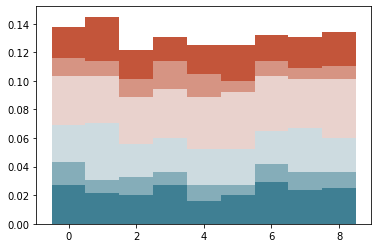

In [43]:
fig, ax = plt.subplots()
bottom=np.zeros(np.unique(clusterResAll).size+1)
for c in range(1,plotRes.shape[1]):
    ax.bar(np.arange(np.unique(clusterResAll).size+1),plotRes[:,c],bottom=bottom,color=np.array(sns.diverging_palette(220, 20, n=6))[c-1],width=1)
    bottom+=plotRes[:,c]
plt.savefig(os.path.join(plotsavepath,'errorsAll_noAH.pdf'))